In [1]:
import pandas as pd

df = pd.read_csv(
    "data_raw/macro_v4_raw.csv",
    index_col=0,
    parse_dates=True
)

df.head()

,US10Y,FEDFUNDS,DXY,OIL,USDINR,US_M2,ECB_ASSETS,NIFTY,GLD,SPY,NIFTY_RET
1995-01-01,NaN,5.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,NaN,5.53,88.730003,NaN,NaN,3508.3,NaN,NaN,NaN,NaN,NaN
1995-01-03,7.88,5.53,89.110001,NaN,NaN,3508.3,NaN,NaN,NaN,26.584358,NaN
1995-01-04,7.82,5.53,89.309998,NaN,NaN,3508.3,NaN,NaN,NaN,26.711367,NaN
1995-01-05,7.88,5.53,88.980003,NaN,NaN,3508.3,NaN,NaN,NaN,26.711367,NaN


In [2]:
pd.infer_freq(df.index)

In [3]:
df.index.to_series().diff().value_counts().head()

1 days    6611
3 days    1519
2 days     106
Name: count, dtype: int64

In [4]:
df[["US_M2", "ECB_ASSETS"]].resample("ME").last().head(10)

,US_M2,ECB_ASSETS
1995-01-31,3455.3,NaN
1995-02-28,3463.2,NaN
1995-03-31,3479.8,NaN
1995-04-30,3508.9,NaN
1995-05-31,3500.3,NaN
1995-06-30,3521.7,NaN
1995-07-31,3560.1,NaN
1995-08-31,3568.2,NaN
1995-09-30,3569.6,NaN
1995-10-31,3582.9,NaN


In [5]:
macro_cols = ["US_M2", "FEDFUNDS"]

df[macro_cols] = (
    df[macro_cols]
    .resample("ME")
    .last()
    .shift(1)          # 1 month publication lag
    .reindex(df.index)
    .ffill()
)

In [6]:
df[["US_M2"]].loc["1995-01":"1995-03"]

,US_M2
1995-01-01,NaN
1995-01-02,NaN
1995-01-03,NaN
1995-01-04,NaN
1995-01-05,NaN
...,...
1995-03-27,3455.3
1995-03-28,3455.3
1995-03-29,3455.3
1995-03-30,3455.3


In [7]:
from src.regime_engine import RegimeEngine

engine = RegimeEngine()

In [8]:
from src.walk_forward import WalkForwardEngine

In [9]:
from src.regime_engine import RegimeEngine

engine = RegimeEngine()

train = df.loc["2004":"2013"]

engine.fit(train)

regimes = engine.predict(df.loc["2014"])

regimes.head()

2014-01-01        NaN
2014-01-02        NaN
2014-01-03        NaN
2014-01-06    neutral
2014-01-07    neutral
dtype: object

In [10]:
wf = WalkForwardEngine(df)

oos_regimes = wf.run()

oos_regimes.head()

V5 Start Date (Full Feature Availability): 2007-09-18 00:00:00
Generated 9 walk-forward splits.
Training 2007-09-18 00:00:00 → 2017-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2018-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2019-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2020-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2021-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2022-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2023-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2024-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2025-09-18 00:00:00


2017-09-18        NaN
2017-09-19        NaN
2017-09-20        NaN
2017-09-21    neutral
2017-09-22    neutral
dtype: object

In [11]:
wf = WalkForwardEngine(df)
oos_regimes = wf.run()

oos_regimes.value_counts()

V5 Start Date (Full Feature Availability): 2007-09-18 00:00:00
Generated 9 walk-forward splits.
Training 2007-09-18 00:00:00 → 2017-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2018-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2019-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2020-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2021-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2022-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2023-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2024-09-18 00:00:00
Training 2007-09-18 00:00:00 → 2025-09-18 00:00:00


neutral     2002
risk_on      135
risk_off      75
Name: count, dtype: int64

In [12]:
oos_regimes.index.duplicated().sum()

np.int64(6)

In [13]:
oos_regimes = oos_regimes[~oos_regimes.index.duplicated(keep="last")]

In [14]:
aligned_df = df.loc[oos_regimes.index]

In [15]:
pd.crosstab(
    oos_regimes,
    aligned_df["NIFTY_RET"] > 0
)

NIFTY_RET,False,True
row_0,,
neutral,981,1015
risk_off,38,37
risk_on,66,69


In [16]:
aligned_df = df.loc[oos_regimes.index].copy()
aligned_df["regime"] = oos_regimes

aligned_df.groupby("regime")["NIFTY_RET"].mean()

regime
neutral     0.000402
risk_off    0.000528
risk_on     0.001357
Name: NIFTY_RET, dtype: float64

In [17]:
aligned_df.groupby("regime")["NIFTY_RET"].std()

regime
neutral     0.009333
risk_off    0.008945
risk_on     0.018963
Name: NIFTY_RET, dtype: float64

In [18]:
len(oos_regimes)

2233

In [19]:
df.columns

Index(['US10Y', 'FEDFUNDS', 'DXY', 'OIL', 'USDINR', 'US_M2', 'ECB_ASSETS',
       'NIFTY', 'GLD', 'SPY', 'NIFTY_RET'],
      dtype='str')

In [20]:
for col in df.columns:
    print(col)

US10Y
FEDFUNDS
DXY
OIL
USDINR
US_M2
ECB_ASSETS
NIFTY
GLD
SPY
NIFTY_RET


In [21]:
[col for col in df.columns if "NIFT" in col.upper()]

['NIFTY', 'NIFTY_RET']

In [22]:
from src.metrics import sharpe_ratio

In [23]:
wf = WalkForwardEngine(df)

splits = wf._generate_splits()

splits[:3]

V5 Start Date (Full Feature Availability): 2007-09-18 00:00:00
Generated 9 walk-forward splits.


[{'train_start': Timestamp('2007-09-18 00:00:00'),
  'train_end': Timestamp('2017-09-18 00:00:00'),
  'test_start': Timestamp('2017-09-18 00:00:00'),
  'test_end': Timestamp('2018-09-18 00:00:00')},
 {'train_start': Timestamp('2007-09-18 00:00:00'),
  'train_end': Timestamp('2018-09-18 00:00:00'),
  'test_start': Timestamp('2018-09-18 00:00:00'),
  'test_end': Timestamp('2019-09-18 00:00:00')},
 {'train_start': Timestamp('2007-09-18 00:00:00'),
  'train_end': Timestamp('2019-09-18 00:00:00'),
  'test_start': Timestamp('2019-09-18 00:00:00'),
  'test_end': Timestamp('2020-09-18 00:00:00')}]

In [24]:
from src.metrics import annualized_return, sharpe_ratio, max_drawdown

In [25]:
from src.walk_forward import WalkForwardEngine

wf = WalkForwardEngine(df)

splits = wf._generate_splits()

splits[:3]

V5 Start Date (Full Feature Availability): 2007-09-18 00:00:00
Generated 9 walk-forward splits.


[{'train_start': Timestamp('2007-09-18 00:00:00'),
  'train_end': Timestamp('2017-09-18 00:00:00'),
  'test_start': Timestamp('2017-09-18 00:00:00'),
  'test_end': Timestamp('2018-09-18 00:00:00')},
 {'train_start': Timestamp('2007-09-18 00:00:00'),
  'train_end': Timestamp('2018-09-18 00:00:00'),
  'test_start': Timestamp('2018-09-18 00:00:00'),
  'test_end': Timestamp('2019-09-18 00:00:00')},
 {'train_start': Timestamp('2007-09-18 00:00:00'),
  'train_end': Timestamp('2019-09-18 00:00:00'),
  'test_start': Timestamp('2019-09-18 00:00:00'),
  'test_end': Timestamp('2020-09-18 00:00:00')}]

In [26]:
from src.strategy_engine import StrategyEngine

In [27]:
strategy = StrategyEngine()

strategy_df = strategy.run(
    df,
    oos_regimes
)

strategy_df.head()

,US10Y,FEDFUNDS,DXY,OIL,USDINR,US_M2,ECB_ASSETS,NIFTY,GLD,SPY,NIFTY_RET,regime,exposure,strategy_ret,equity_curve
2017-09-18,2.23,1.15,92.050003,49.910000,64.120201,13610.9,4308875.0,10153.099609,124.360001,219.274490,0.006713,NaN,0.0,0.000000,1.000000
2017-09-19,2.24,1.15,91.790001,49.480000,64.214699,13610.9,4308875.0,10147.549805,124.620003,219.493958,-0.000547,NaN,0.0,-0.000000,1.000000
2017-09-20,2.28,1.15,92.510002,50.410000,64.298698,13610.9,4308875.0,10141.150391,123.620003,219.572968,-0.000631,NaN,0.0,-0.000000,1.000000
2017-09-21,2.27,1.15,92.260002,50.549999,64.283699,13610.9,4308875.0,10121.900391,122.680000,218.984680,-0.001898,neutral,1.0,-0.001898,0.998102
2017-09-22,2.26,1.15,92.169998,50.660000,64.802299,13610.9,4328211.0,9964.400391,123.239998,219.028610,-0.015560,neutral,1.0,-0.015560,0.982571


<Axes: >

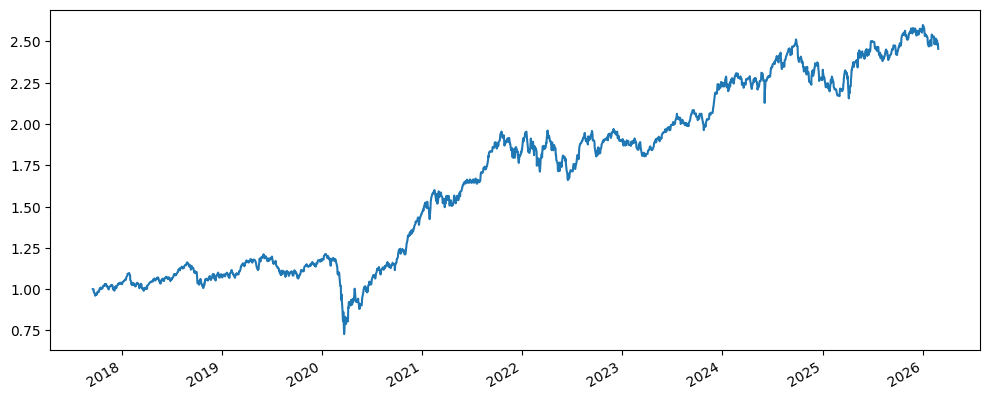

In [28]:
strategy_df["equity_curve"].plot(figsize=(12,5))

In [29]:
import numpy as np

# Buy & Hold
bh = df.loc[oos_regimes.index]["NIFTY_RET"]
bh_curve = (1 + bh).cumprod()

# Strategy
strategy_ret = strategy_df["strategy_ret"]
strategy_curve = strategy_df["equity_curve"]

def perf_stats(returns):

    mean = returns.mean()
    std = returns.std()

    sharpe = (mean / std) * np.sqrt(252)

    cagr = (1 + returns).prod() ** (252 / len(returns)) - 1

    dd = ( (1 + returns).cumprod() /
           (1 + returns).cumprod().cummax() - 1 ).min()

    return sharpe, cagr, dd


bh_stats = perf_stats(bh)
strategy_stats = perf_stats(strategy_ret)

print("Buy & Hold  -> Sharpe, CAGR, MaxDD")
print(bh_stats)

print("Strategy    -> Sharpe, CAGR, MaxDD")
print(strategy_stats)

Buy & Hold  -> Sharpe, CAGR, MaxDD
(np.float64(0.7190975595306497), np.float64(0.10876829557976708), np.float64(-0.38439852452741974))
Strategy    -> Sharpe, CAGR, MaxDD
(np.float64(0.6954892558500251), np.float64(0.10667630630831915), np.float64(-0.39954359432867914))


In [30]:
aligned_df["regime"].value_counts()

regime
neutral     1996
risk_on      135
risk_off      75
Name: count, dtype: int64

In [31]:
aligned_df.loc["2020-01":"2020-07"][["NIFTY","regime"]]

,NIFTY,regime
2020-01-01,12182.500000,risk_on
2020-01-02,12282.200195,risk_on
2020-01-03,12226.650391,risk_off
2020-01-06,11993.049805,risk_off
2020-01-07,12052.950195,risk_off
...,...,...
2020-07-27,11131.799805,neutral
2020-07-28,11300.549805,neutral
2020-07-29,11202.849609,neutral
2020-07-30,11102.150391,neutral


In [32]:
# Daily NIFTY price series
daily_nifty = df["NIFTY"].dropna()

# Convert to month-end close
monthly_nifty_series = daily_nifty.resample("ME").last()

In [33]:
from src.trend_engine import TrendEngine

trend_engine = TrendEngine(lookback=12)

trend_signal = trend_engine.generate_signal(monthly_nifty_series)

trend_signal.head()

,trend_signal
2007-09-30,0
2007-10-31,0
2007-11-30,0
2007-12-31,0
2008-01-31,0


In [34]:
len(monthly_nifty_series), len(trend_signal)

(222, 222)

In [35]:
trend_signal["trend_signal"].mean()

np.float64(0.7432432432432432)

In [36]:
trend_signal.loc["2007":"2009"]
trend_signal.loc["2019":"2021"]

,trend_signal
2019-01-31,0
2019-02-28,1
2019-03-31,1
2019-04-30,1
2019-05-31,1
2019-06-30,1
2019-07-31,0
2019-08-31,0
2019-09-30,1
2019-10-31,1


In [37]:
combined = trend_signal.join(regime_signal, how="inner")

combined.corr()

NameError: name 'regime_signal' is not defined

NameError: name 'plt' is not defined

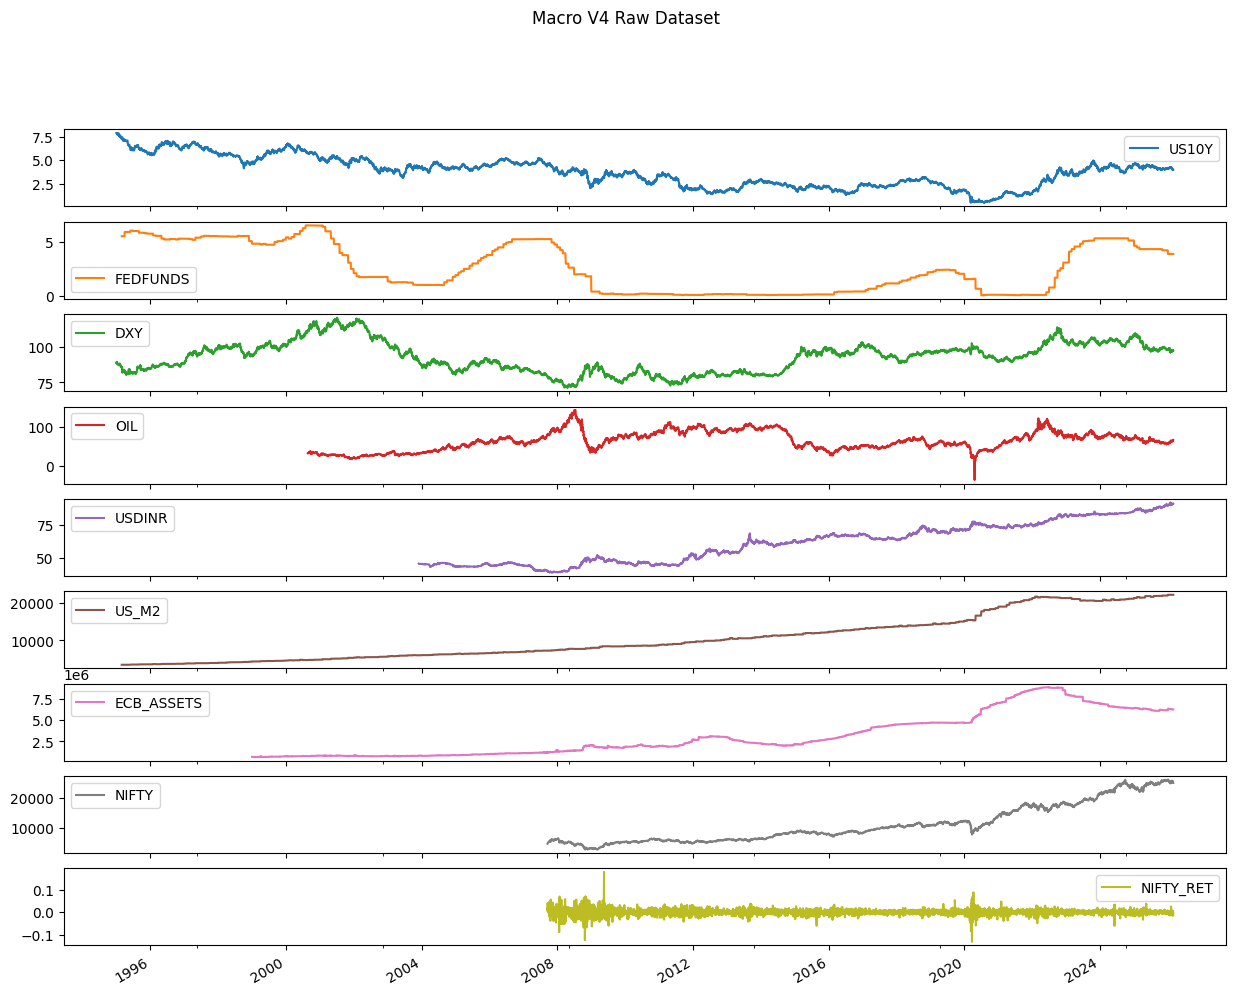

In [ ]:
df.plot(
    subplots=True,
    figsize=(15,12),
    title="Macro V4 Raw Dataset"
)

plt.show()

In [ ]:
df.isna().sum()

US10Y            2
FEDFUNDS         0
DXY              1
OIL           1492
USDINR        2357
US_M2            1
ECB_ASSETS    1059
dtype: int64

In [ ]:
df.first_valid_index()

Timestamp('1995-01-01 00:00:00')

In [ ]:
df.last_valid_index()

Timestamp('2026-02-25 00:00:00')

In [ ]:
df.dropna().index[0]

Timestamp('2003-12-01 00:00:00')

In [ ]:
df.dropna().shape

(5878, 7)

In [ ]:
df_clean = df.dropna()

df_clean.head()

,US10Y,FEDFUNDS,DXY,OIL,USDINR,US_M2,ECB_ASSETS
2003-12-01,4.40,0.98,90.349998,29.950001,45.709999,6092.5,833339.0
2003-12-02,4.38,0.98,89.639999,30.780001,45.629002,6092.5,833339.0
2003-12-03,4.41,0.98,89.500000,31.100000,45.549999,6092.5,833339.0
2003-12-04,4.38,0.98,89.599998,31.260000,45.548000,6092.5,833339.0
2003-12-05,4.23,0.98,89.139999,30.730000,45.449001,6092.5,858338.0


In [ ]:
df_clean.to_csv(
    "../data_processed/macro_v4_clean.csv"
)

print("Clean dataset saved.")

OSError: Cannot save file into a non-existent directory: '../data_processed'

In [ ]:
import pandas as pd

df = pd.read_csv(
    "../data_processed/macro_v4_clean.csv",
    index_col=0,
    parse_dates=True
)

df.head()

,US10Y,FEDFUNDS,DXY,OIL,USDINR,US_M2,ECB_ASSETS
2003-12-01,4.40,0.98,90.349998,29.950001,45.709999,6092.5,833339.0
2003-12-02,4.38,0.98,89.639999,30.780001,45.629002,6092.5,833339.0
2003-12-03,4.41,0.98,89.500000,31.100000,45.549999,6092.5,833339.0
2003-12-04,4.38,0.98,89.599998,31.260000,45.548000,6092.5,833339.0
2003-12-05,4.23,0.98,89.139999,30.730000,45.449001,6092.5,858338.0


In [ ]:
df_features = df.copy()

In [ ]:
# Rate changes

df_features["US10Y_CHG"] = df_features["US10Y"].diff()

df_features["FEDFUNDS_CHG"] = df_features["FEDFUNDS"].diff()

In [ ]:
df_features[
    ["US10Y","US10Y_CHG","FEDFUNDS","FEDFUNDS_CHG"]
].head(10)

,US10Y,US10Y_CHG,FEDFUNDS,FEDFUNDS_CHG
2003-12-01,4.40,NaN,0.98,NaN
2003-12-02,4.38,-0.02,0.98,0.0
2003-12-03,4.41,0.03,0.98,0.0
2003-12-04,4.38,-0.03,0.98,0.0
2003-12-05,4.23,-0.15,0.98,0.0
2003-12-08,4.29,0.06,0.98,0.0
2003-12-09,4.32,0.03,0.98,0.0
2003-12-10,4.30,-0.02,0.98,0.0
2003-12-11,4.27,-0.03,0.98,0.0
2003-12-12,4.26,-0.01,0.98,0.0


In [ ]:
# Dollar momentum

df_features["DXY_RET"] = df_features["DXY"].pct_change()

In [ ]:
# Oil momentum

df_features["OIL_RET"] = df_features["OIL"].pct_change()

In [ ]:
# INR weakness / strength

df_features["USDINR_RET"] = df_features["USDINR"].pct_change()

In [ ]:
df_features[
    ["DXY_RET","OIL_RET","USDINR_RET"]
].head(10)

,DXY_RET,OIL_RET,USDINR_RET
2003-12-01,NaN,NaN,NaN
2003-12-02,-0.007858,0.027713,-0.001772
2003-12-03,-0.001562,0.010396,-0.001731
2003-12-04,0.001117,0.005145,-0.000044
2003-12-05,-0.005134,-0.016955,-0.002174
2003-12-08,-0.004375,0.044582,0.000462
2003-12-09,-0.001577,-0.010592,-0.000858
2003-12-10,0.002708,0.003778,-0.001321
2003-12-11,0.000338,-0.000941,0.001719
2003-12-12,-0.004388,0.037363,-0.000594


In [ ]:
# US Liquidity growth

df_features["US_M2_GROWTH"] = df_features["US_M2"].pct_change()

In [ ]:
# ECB liquidity growth

df_features["ECB_LIQ_GROWTH"] = df_features["ECB_ASSETS"].pct_change()

In [ ]:
# Global Liquidity Composite

df_features["GLOBAL_LIQUIDITY"] = (

    df_features["US_M2_GROWTH"]
    +
    df_features["ECB_LIQ_GROWTH"]

) / 2

In [ ]:
df_features[
    [
        "US_M2_GROWTH",
        "ECB_LIQ_GROWTH",
        "GLOBAL_LIQUIDITY"
    ]
].head(10)

,US_M2_GROWTH,ECB_LIQ_GROWTH,GLOBAL_LIQUIDITY
2003-12-01,NaN,NaN,NaN
2003-12-02,0.000000,0.000000,0.000000
2003-12-03,0.000000,0.000000,0.000000
2003-12-04,0.000000,0.000000,0.000000
2003-12-05,0.000000,0.029999,0.014999
2003-12-08,0.002544,0.000000,0.001272
2003-12-09,0.000000,0.000000,0.000000
2003-12-10,0.000000,0.000000,0.000000
2003-12-11,0.000000,0.000000,0.000000
2003-12-12,0.000000,-0.013157,-0.006578


In [ ]:
from scipy.stats import zscore

In [ ]:
# Liquidity Z-score (correct version)

df_features["LIQ_Z"] = zscore(
    df_features["GLOBAL_LIQUIDITY"],
    nan_policy="omit"
)

In [ ]:
df_features[
    ["GLOBAL_LIQUIDITY","LIQ_Z"]
].head(15)

,GLOBAL_LIQUIDITY,LIQ_Z
2003-12-01,NaN,NaN
2003-12-02,0.000000,-0.079595
2003-12-03,0.000000,-0.079595
2003-12-04,0.000000,-0.079595
2003-12-05,0.014999,3.955561
2003-12-08,0.001272,0.262617
2003-12-09,0.000000,-0.079595
2003-12-10,0.000000,-0.079595
2003-12-11,0.000000,-0.079595
2003-12-12,-0.006578,-1.849339


In [ ]:
# Rolling mean (1 year window)

rolling_mean = df_features["GLOBAL_LIQUIDITY"].rolling(
    window=252
).mean()

In [ ]:
rolling_std = df_features["GLOBAL_LIQUIDITY"].rolling(
    window=252
).std()

In [ ]:
# Institutional Liquidity Signal

df_features["LIQ_Z_ROLL"] = (

    df_features["GLOBAL_LIQUIDITY"]
    - rolling_mean

) / rolling_std

In [ ]:
df_features[
    ["GLOBAL_LIQUIDITY","LIQ_Z","LIQ_Z_ROLL"]
].head(300)

,GLOBAL_LIQUIDITY,LIQ_Z,LIQ_Z_ROLL
2003-12-01,NaN,NaN,NaN
2003-12-02,0.000000,-0.079595,NaN
2003-12-03,0.000000,-0.079595,NaN
2003-12-04,0.000000,-0.079595,NaN
2003-12-05,0.014999,3.955561,NaN
...,...,...,...
2005-01-11,0.000000,-0.079595,-0.091792
2005-01-12,0.000000,-0.079595,-0.090858
2005-01-13,0.000000,-0.079595,-0.090858
2005-01-14,0.004240,1.061148,1.383477


In [ ]:
df_features["REGIME"] = 0

df_features.loc[
    df_features["LIQ_Z_ROLL"] > 0.5,
    "REGIME"
] = 1

In [ ]:
df_features.loc[
    df_features["LIQ_Z_ROLL"] < -0.5,
    "REGIME"
] = -1

In [ ]:
df_features[
    ["LIQ_Z_ROLL","REGIME"]
].tail(50)

,LIQ_Z_ROLL,REGIME
2025-12-18,0.009557,0
2025-12-19,0.339469,0
2025-12-22,1.377544,1
2025-12-23,0.002754,0
2025-12-24,0.001534,0
2025-12-25,0.001090,0
2025-12-26,1.692041,1
2025-12-29,0.759829,1
2025-12-30,-0.008697,0
2025-12-31,-0.009547,0


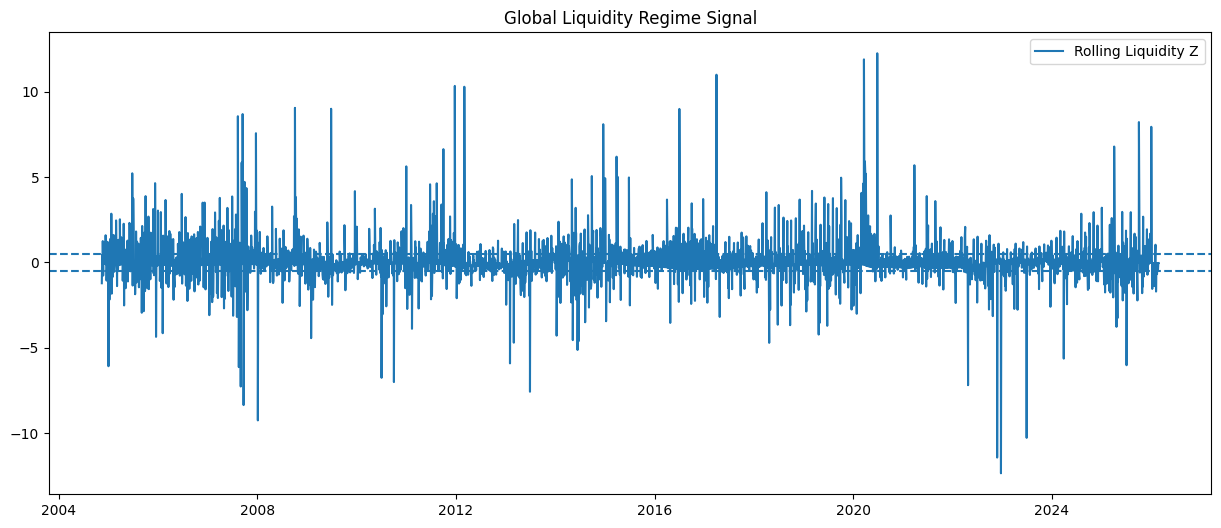

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.plot(
    df_features.index,
    df_features["LIQ_Z_ROLL"],
    label="Rolling Liquidity Z"
)

plt.axhline(0.5, linestyle="--")
plt.axhline(-0.5, linestyle="--")

plt.title("Global Liquidity Regime Signal")

plt.legend()

plt.show()

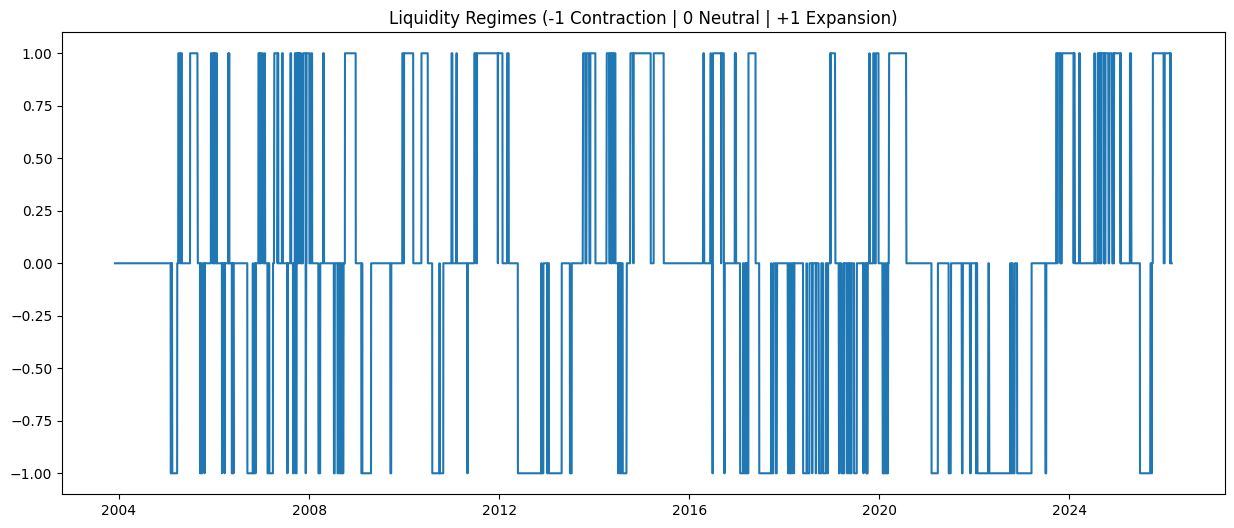

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(
    df_features.index,
    df_features["REGIME"],
)

plt.title("Liquidity Regimes (-1 Contraction | 0 Neutral | +1 Expansion)")

plt.show()

In [ ]:
# Smooth liquidity (3 month approx)

df_features["GLOBAL_LIQ_SMOOTH"] = (

    df_features["GLOBAL_LIQUIDITY"]
    .rolling(window=60)
    .mean()

)

In [ ]:
rolling_mean = df_features["GLOBAL_LIQ_SMOOTH"].rolling(
    window=252
).mean()

rolling_std = df_features["GLOBAL_LIQ_SMOOTH"].rolling(
    window=252
).std()


df_features["LIQ_Z_ROLL"] = (

    df_features["GLOBAL_LIQ_SMOOTH"]
    - rolling_mean

) / rolling_std

In [ ]:
df_features["REGIME"] = 0

df_features.loc[
    df_features["LIQ_Z_ROLL"] > 0.5,
    "REGIME"
] = 1

df_features.loc[
    df_features["LIQ_Z_ROLL"] < -0.5,
    "REGIME"
] = -1

In [ ]:
# Require regime persistence

df_features["REGIME"] = (

    df_features["REGIME"]
    .rolling(window=20)
    .mean()

)

In [ ]:
df_features["REGIME"] = 0

df_features.loc[
    df_features["LIQ_Z_ROLL"] > 1.0,
    "REGIME"
] = 1

df_features.loc[
    df_features["LIQ_Z_ROLL"] < -1.0,
    "REGIME"
] = -1

In [ ]:
df_monthly = df_features.resample("ME").last()

df_monthly.head()

,US10Y,FEDFUNDS,DXY,OIL,USDINR,US_M2,ECB_ASSETS,US10Y_CHG,FEDFUNDS_CHG,DXY_RET,OIL_RET,USDINR_RET,US_M2_GROWTH,ECB_LIQ_GROWTH,GLOBAL_LIQUIDITY,LIQ_Z,LIQ_Z_ROLL,REGIME,GLOBAL_LIQ_SMOOTH
2003-12-31,4.27,0.98,86.919998,32.520000,45.529999,6091.6,835157.0,-0.02,0.0,-0.000920,-0.008234,0.000681,0.0,0.000000,0.000000,-0.079595,NaN,0,NaN
2004-01-31,4.16,1.00,87.199997,33.049999,45.004002,6015.4,824392.0,-0.06,0.0,-0.004339,0.007315,-0.005898,0.0,0.001351,0.000675,0.102089,NaN,0,NaN
2004-02-29,3.99,1.01,87.309998,36.160000,45.195999,6089.2,824024.0,-0.06,0.0,-0.004220,0.018305,0.000620,0.0,0.008682,0.004341,1.088300,NaN,0,-0.000357
2004-03-31,3.86,1.00,87.610001,35.759998,43.334000,6174.9,830349.0,-0.05,0.0,-0.009273,-0.013517,-0.010933,0.0,0.000000,0.000000,-0.079595,NaN,0,-0.000004
2004-04-30,4.53,1.00,90.480003,37.380001,44.284000,6199.0,853538.0,-0.02,0.0,-0.000994,0.001876,-0.000790,0.0,0.012839,0.006420,1.647453,NaN,0,0.000583


In [ ]:
rolling_mean = df_monthly["GLOBAL_LIQUIDITY"].rolling(
    window=24
).mean()

rolling_std = df_monthly["GLOBAL_LIQUIDITY"].rolling(
    window=24
).std()

df_monthly["LIQ_Z_ROLL"] = (

    df_monthly["GLOBAL_LIQUIDITY"]
    - rolling_mean

) / rolling_std

In [ ]:
df_monthly["REGIME"] = 0

df_monthly.loc[
    df_monthly["LIQ_Z_ROLL"] > 0.5,
    "REGIME"
] = 1

df_monthly.loc[
    df_monthly["LIQ_Z_ROLL"] < -0.5,
    "REGIME"
] = -1

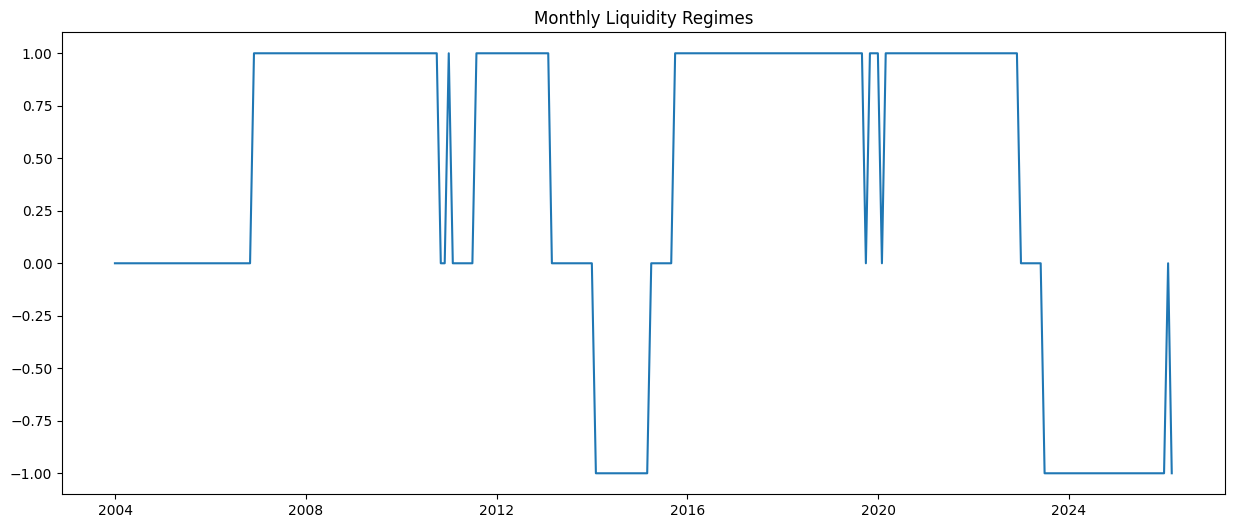

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(
    df_monthly.index,
    df_monthly["REGIME"]
)

plt.title("Monthly Liquidity Regimes")

plt.show()

In [ ]:
df_monthly["GLOBAL_LIQ_LEVEL"] = (

    df_monthly["US_M2"]
    +
    df_monthly["ECB_ASSETS"]

)

In [ ]:
rolling_mean = df_monthly["GLOBAL_LIQ_LEVEL"].rolling(
    window=36
).mean()

rolling_std = df_monthly["GLOBAL_LIQ_LEVEL"].rolling(
    window=36
).std()

df_monthly["LIQ_Z_ROLL"] = (

    df_monthly["GLOBAL_LIQ_LEVEL"]
    - rolling_mean

) / rolling_std

In [ ]:
df_monthly["REGIME"] = 0

df_monthly.loc[
    df_monthly["LIQ_Z_ROLL"] > 0.75,
    "REGIME"
] = 1

df_monthly.loc[
    df_monthly["LIQ_Z_ROLL"] < -0.75,
    "REGIME"
] = -1

In [ ]:
import yfinance as yf

In [ ]:
nifty = yf.download(
    "^NSEI",
    start="2003-01-01",
    auto_adjust=True
)["Close"]

nifty.head()

[*********************100%***********************]  1 of 1 completed


Ticker,^NSEI
Date,
2007-09-17,4494.649902
2007-09-18,4546.200195
2007-09-19,4732.350098
2007-09-20,4747.549805
2007-09-21,4837.549805


In [ ]:
nifty_m = nifty.resample("ME").last()

In [ ]:
df_model = df_monthly.join(
    nifty_m,
    how="inner"
)

In [ ]:
df_model.head()

,US10Y,FEDFUNDS,DXY,OIL,USDINR,US_M2,ECB_ASSETS,US10Y_CHG,FEDFUNDS_CHG,DXY_RET,...,USDINR_RET,US_M2_GROWTH,ECB_LIQ_GROWTH,GLOBAL_LIQUIDITY,LIQ_Z,LIQ_Z_ROLL,REGIME,GLOBAL_LIQ_SMOOTH,GLOBAL_LIQ_LEVEL,^NSEI
2007-09-30,4.59,4.94,77.720001,81.660004,39.575001,7331.3,1250396.0,0.01,0.0,-0.007914,...,-0.001967,0.000000,0.051121,0.025561,6.796804,1.802461,1,0.000505,1257727.3,5021.350098
2007-10-31,4.48,4.76,76.480003,94.529999,39.174000,7370.8,1263504.0,0.08,0.0,-0.003777,...,-0.003460,0.000000,0.000000,0.000000,-0.079595,1.806619,1,0.000613,1270874.8,5900.649902
2007-11-30,3.97,4.49,76.150002,88.709999,39.455002,7456.3,1297266.0,0.03,0.0,0.007408,...,-0.002982,0.000000,0.009135,0.004567,1.149141,1.975643,1,0.000757,1304722.3,5762.750000
2007-12-31,4.04,4.24,76.699997,95.980003,39.244999,7526.4,1511244.0,-0.07,0.0,0.006298,...,0.000000,0.001677,0.000000,0.000838,0.145969,3.279222,1,0.001925,1518770.4,6138.600098
2008-01-31,3.67,3.94,75.180000,91.750000,39.313999,7483.4,1337542.0,-0.11,0.0,0.001999,...,-0.000839,0.000000,0.000000,0.000000,-0.079595,1.785931,1,0.000794,1345025.4,5137.450195


In [ ]:
df_model.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 222 entries, 2007-09-30 to 2026-02-28
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   US10Y              222 non-null    float64
 1   FEDFUNDS           222 non-null    float64
 2   DXY                222 non-null    float64
 3   OIL                222 non-null    float64
 4   USDINR             222 non-null    float64
 5   US_M2              222 non-null    float64
 6   ECB_ASSETS         222 non-null    float64
 7   US10Y_CHG          222 non-null    float64
 8   FEDFUNDS_CHG       222 non-null    float64
 9   DXY_RET            222 non-null    float64
 10  OIL_RET            222 non-null    float64
 11  USDINR_RET         222 non-null    float64
 12  US_M2_GROWTH       222 non-null    float64
 13  ECB_LIQ_GROWTH     222 non-null    float64
 14  GLOBAL_LIQUIDITY   222 non-null    float64
 15  LIQ_Z              222 non-null    float64
 16  LIQ_Z_ROLL        

In [ ]:
df_model = df_model.rename(
    columns={"^NSEI": "NIFTY"}
)

In [ ]:
df_model[['NIFTY']].head()

,NIFTY
2007-09-30,5021.350098
2007-10-31,5900.649902
2007-11-30,5762.750000
2007-12-31,6138.600098
2008-01-31,5137.450195


In [ ]:
df_model[['GLOBAL_LIQUIDITY','NIFTY']].head(10)

,GLOBAL_LIQUIDITY,NIFTY
2007-09-30,0.025561,5021.350098
2007-10-31,0.000000,5900.649902
2007-11-30,0.004567,5762.750000
2007-12-31,0.000838,6138.600098
2008-01-31,0.000000,5137.450195
2008-02-29,-0.000790,5223.500000
2008-03-31,0.000594,4734.500000
2008-04-30,0.000000,5165.899902
2008-05-31,-0.000194,4870.100098
2008-06-30,-0.000304,4040.550049


In [ ]:
df_model.to_csv(
    "../data_processed/macro_nifty_aligned.csv"
)

In [ ]:
import pandas as pd

df_check = pd.read_csv(
    "../data_processed/macro_nifty_aligned.csv",
    index_col=0,
    parse_dates=True
)

df_check.head()

,US10Y,FEDFUNDS,DXY,OIL,USDINR,US_M2,ECB_ASSETS,US10Y_CHG,FEDFUNDS_CHG,DXY_RET,...,USDINR_RET,US_M2_GROWTH,ECB_LIQ_GROWTH,GLOBAL_LIQUIDITY,LIQ_Z,LIQ_Z_ROLL,REGIME,GLOBAL_LIQ_SMOOTH,GLOBAL_LIQ_LEVEL,NIFTY
2007-09-30,4.59,4.94,77.720001,81.660004,39.575001,7331.3,1250396.0,0.01,0.0,-0.007914,...,-0.001967,0.000000,0.051121,0.025561,6.796804,1.802461,1,0.000505,1257727.3,5021.350098
2007-10-31,4.48,4.76,76.480003,94.529999,39.174000,7370.8,1263504.0,0.08,0.0,-0.003777,...,-0.003460,0.000000,0.000000,0.000000,-0.079595,1.806619,1,0.000613,1270874.8,5900.649902
2007-11-30,3.97,4.49,76.150002,88.709999,39.455002,7456.3,1297266.0,0.03,0.0,0.007408,...,-0.002982,0.000000,0.009135,0.004567,1.149141,1.975643,1,0.000757,1304722.3,5762.750000
2007-12-31,4.04,4.24,76.699997,95.980003,39.244999,7526.4,1511244.0,-0.07,0.0,0.006298,...,0.000000,0.001677,0.000000,0.000838,0.145969,3.279222,1,0.001925,1518770.4,6138.600098
2008-01-31,3.67,3.94,75.180000,91.750000,39.313999,7483.4,1337542.0,-0.11,0.0,0.001999,...,-0.000839,0.000000,0.000000,0.000000,-0.079595,1.785931,1,0.000794,1345025.4,5137.450195


<Axes: title={'center': 'Global Liquidity vs NIFTY'}>

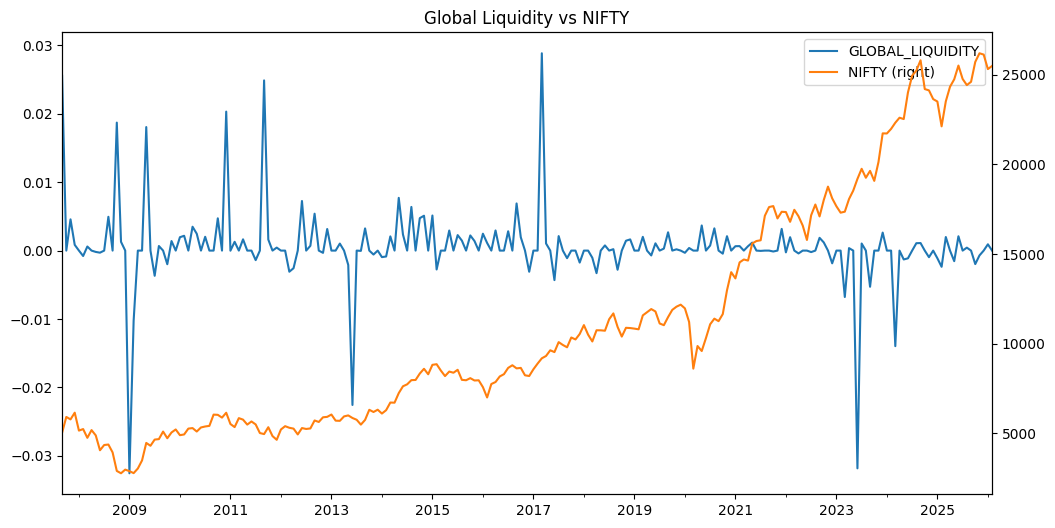

In [ ]:
df_check[['GLOBAL_LIQUIDITY','NIFTY']].plot(
    secondary_y='NIFTY',
    figsize=(12,6),
    title="Global Liquidity vs NIFTY"
)

In [ ]:
df_check['NIFTY_RET'] = df_check['NIFTY'].pct_change()

<Axes: title={'center': 'Liquidity vs NIFTY Monthly Returns'}>

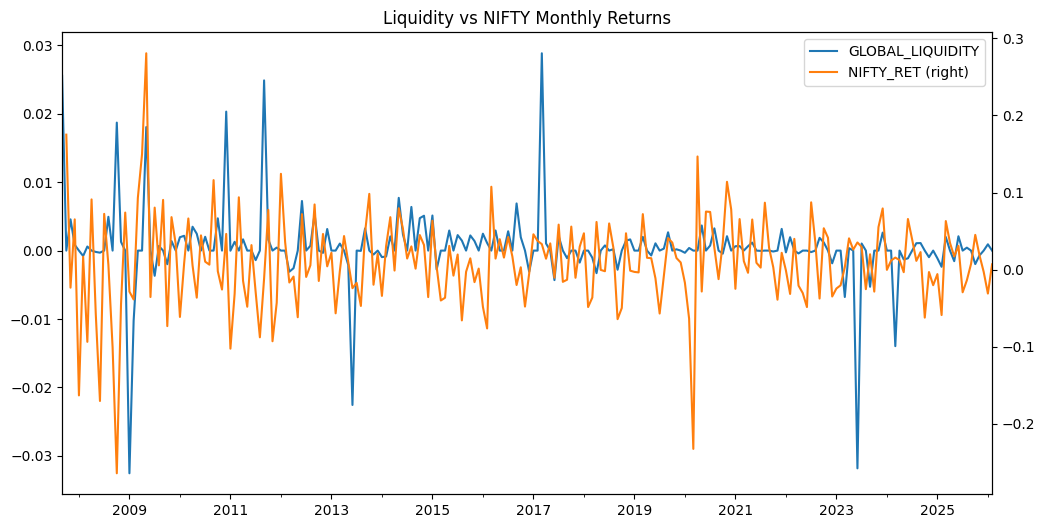

In [ ]:
df_check[['GLOBAL_LIQUIDITY','NIFTY_RET']].plot(
    secondary_y='NIFTY_RET',
    figsize=(12,6),
    title="Liquidity vs NIFTY Monthly Returns"
)

In [ ]:
df_check[['GLOBAL_LIQUIDITY','NIFTY_RET']].corr()

,GLOBAL_LIQUIDITY,NIFTY_RET
GLOBAL_LIQUIDITY,1.000000,0.074813
NIFTY_RET,0.074813,1.000000


In [ ]:
df_check['NIFTY_RET_LAG1'] = df_check['NIFTY_RET'].shift(-1)

In [ ]:
df_check[['GLOBAL_LIQUIDITY','NIFTY_RET_LAG1']].corr()

,GLOBAL_LIQUIDITY,NIFTY_RET_LAG1
GLOBAL_LIQUIDITY,1.000000,0.032994
NIFTY_RET_LAG1,0.032994,1.000000


In [ ]:
df_check.groupby('REGIME')['NIFTY_RET'].mean()

REGIME
-1    0.015652
 0   -0.004727
 1    0.010364
Name: NIFTY_RET, dtype: float64

In [ ]:
df_check.groupby('REGIME')['NIFTY_RET'].agg(
    ['mean','std','min','max','count']
)

,mean,std,min,max,count
REGIME,,,,,
-1,0.015652,0.034058,-0.062203,0.079677,46
0,-0.004727,0.042974,-0.102470,0.098312,34
1,0.010364,0.067916,-0.264103,0.280660,141


<Axes: title={'center': 'NIFTY_RET'}, xlabel='REGIME'>

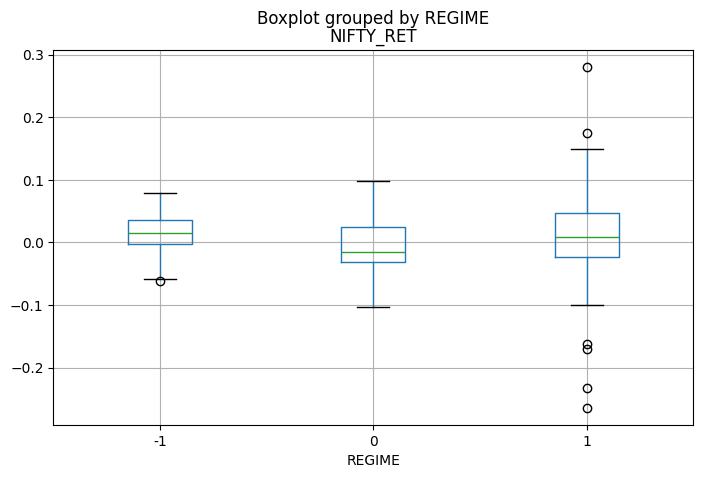

In [ ]:
df_check.boxplot(
    column='NIFTY_RET',
    by='REGIME',
    figsize=(8,5)
)

In [ ]:
df_check.groupby('REGIME')['NIFTY_RET'].sum()

REGIME
-1    0.719993
 0   -0.160732
 1    1.461341
Name: NIFTY_RET, dtype: float64

In [ ]:
df_check['STRAT_RET'] = df_check['NIFTY_RET'].where(
    df_check['REGIME'] != 0,
    0
)

df_check['STRAT_RET'].sum()

np.float64(2.181334558919299)

In [ ]:
df_check['BUY_HOLD'] = (1 + df_check['NIFTY_RET']).cumprod()

df_check['STRATEGY'] = (1 + df_check['STRAT_RET']).cumprod()

<Axes: title={'center': 'Buy & Hold vs Liquidity Regime Filter'}>

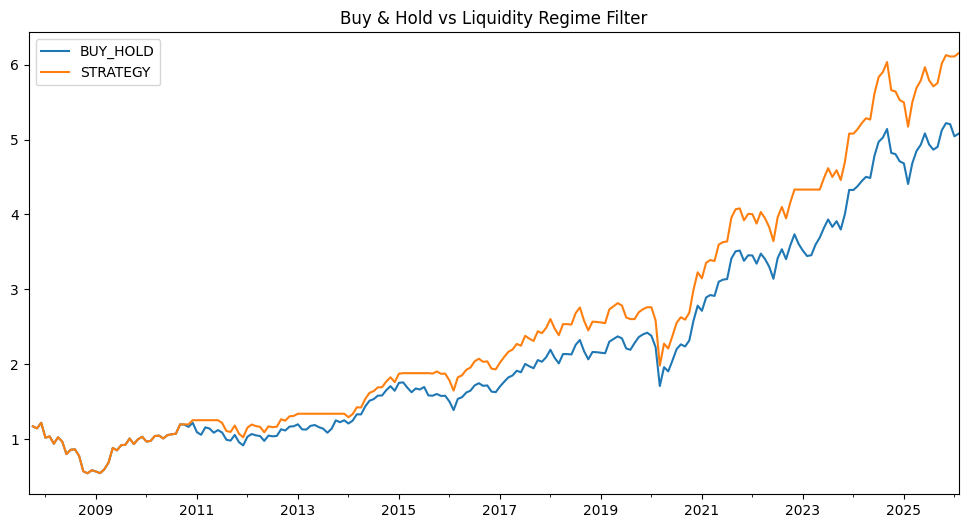

In [ ]:
df_check[['BUY_HOLD','STRATEGY']].plot(
    figsize=(12,6),
    title="Buy & Hold vs Liquidity Regime Filter"
)

In [ ]:
df_check['REGIME_LAG'] = df_check['REGIME'].shift(1)

In [ ]:
df_check['STRAT_REAL'] = df_check['NIFTY_RET'].where(
    df_check['REGIME_LAG'] != 0,
    0
)

In [ ]:
df_check['STRATEGY_REAL'] = (
    1 + df_check['STRAT_REAL']
).cumprod()

<Axes: title={'center': 'Realistic Regime Strategy vs Buy & Hold'}>

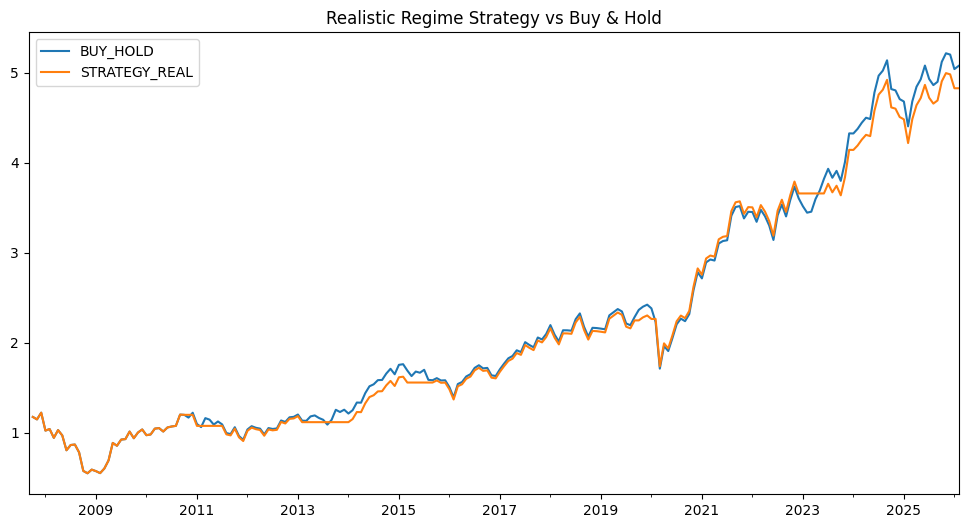

In [ ]:
df_check[['BUY_HOLD','STRATEGY_REAL']].plot(
    figsize=(12,6),
    title="Realistic Regime Strategy vs Buy & Hold"
)

In [ ]:
df_check[['BUY_HOLD','STRATEGY_REAL']].pct_change().min()

BUY_HOLD        -0.264103
STRATEGY_REAL   -0.264103
dtype: float64

In [ ]:
df_check[['BUY_HOLD','STRATEGY_REAL']].pct_change().std()

BUY_HOLD         0.058127
STRATEGY_REAL    0.056057
dtype: float64

In [ ]:
import numpy as np

def annualized_return(series):

    total_return = series.iloc[-1]
    years = len(series) / 12

    return total_return ** (1/years) - 1


print("Buy Hold CAGR:",
      annualized_return(df_check['BUY_HOLD']))

print("Strategy CAGR:",
      annualized_return(df_check['STRATEGY_REAL']))

Buy Hold CAGR: 0.09180187060744505
Strategy CAGR: 0.08884777802403399


In [ ]:
df_check['EXPOSURE'] = 1.0

df_check.loc[df_check['REGIME_LAG'] == -1, 'EXPOSURE'] = 1.25
df_check.loc[df_check['REGIME_LAG'] == 0, 'EXPOSURE'] = 0.5
df_check.loc[df_check['REGIME_LAG'] == 1, 'EXPOSURE'] = 1.0

In [ ]:
df_check['STRAT_WEIGHTED'] = (
    df_check['EXPOSURE'] *
    df_check['NIFTY_RET']
)

In [ ]:
df_check['STRATEGY_WEIGHTED'] = (
    1 + df_check['STRAT_WEIGHTED']
).cumprod()

<Axes: title={'center': 'Exposure Weighted Liquidity Strategy'}>

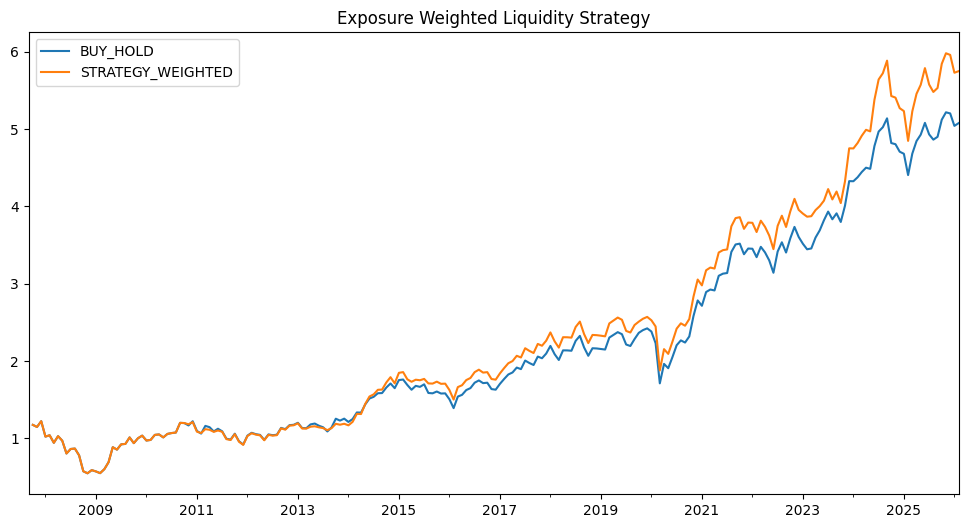

In [ ]:
df_check[['BUY_HOLD','STRATEGY_WEIGHTED']].plot(
    figsize=(12,6),
    title="Exposure Weighted Liquidity Strategy"
)

In [ ]:
print("Weighted Strategy CAGR:",
      annualized_return(
          df_check['STRATEGY_WEIGHTED']
      ))

Weighted Strategy CAGR: 0.09916707901890343


In [ ]:
df_check[['BUY_HOLD','STRATEGY_WEIGHTED']].pct_change().std()

BUY_HOLD             0.058127
STRATEGY_WEIGHTED    0.057886
dtype: float64

In [ ]:
def sharpe(series):

    r = series.pct_change().dropna()

    return (
        r.mean() / r.std()
    ) * (12 ** 0.5)


print("Buy Hold Sharpe:",
      sharpe(df_check['BUY_HOLD']))

print("Weighted Strategy Sharpe:",
      sharpe(df_check['STRATEGY_WEIGHTED']))

Buy Hold Sharpe: 0.4999236450922241
Weighted Strategy Sharpe: 0.5352095847456982


## V4 Liquidity Regime Research — Exposure Test

* Applied 1-month lag to remove look-ahead bias.
* Binary exit strategy did not outperform buy & hold.
* Exposure sizing improved CAGR and Sharpe ratio.
* Liquidity behaves as a risk allocation signal rather than a directional predictor.


In [ ]:
train = df_check.loc[:'2018-12-31']
test = df_check.loc['2019-01-01':]

In [ ]:
print(len(train), len(test))

136 86


In [ ]:
test['BUY_HOLD_OOS'] = (
    1 + test['NIFTY_RET']
).cumprod()

test['STRATEGY_OOS'] = (
    1 + test['STRAT_WEIGHTED']
).cumprod()

<Axes: title={'center': 'Out-of-Sample Performance (2019-Present)'}>

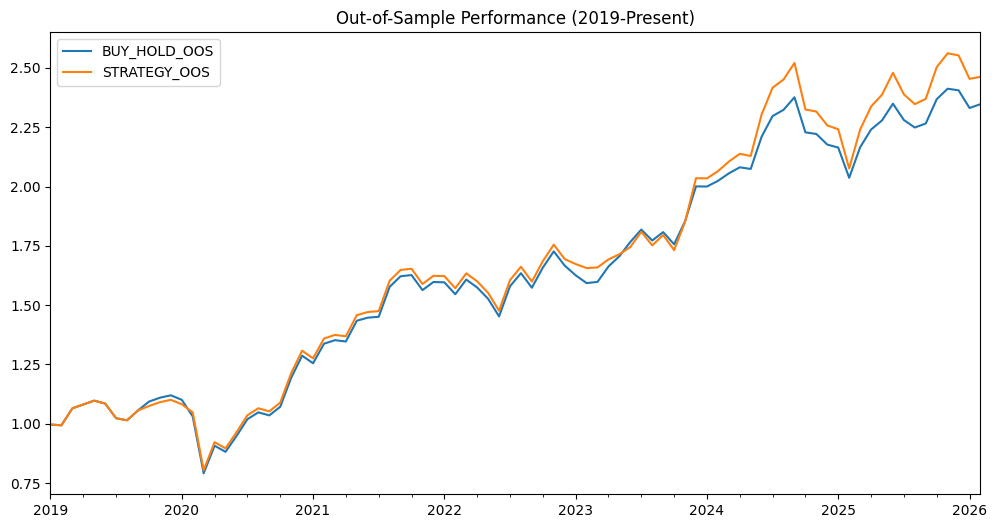

In [ ]:
test[['BUY_HOLD_OOS','STRATEGY_OOS']].plot(
    figsize=(12,6),
    title="Out-of-Sample Performance (2019-Present)"
)

In [ ]:
print("OOS Buy Hold CAGR:",
      annualized_return(
          test['BUY_HOLD_OOS']
      ))

print("OOS Strategy CAGR:",
      annualized_return(
          test['STRATEGY_OOS']
      ))

OOS Buy Hold CAGR: 0.1264310222042042
OOS Strategy CAGR: 0.13398585622067105


In [ ]:
test[['BUY_HOLD_OOS','STRATEGY_OOS']].pct_change().std()

BUY_HOLD_OOS    0.048695
STRATEGY_OOS    0.050205
dtype: float64

In [ ]:
test.columns

Index(['US10Y', 'FEDFUNDS', 'DXY', 'OIL', 'USDINR', 'US_M2', 'ECB_ASSETS',
       'US10Y_CHG', 'FEDFUNDS_CHG', 'DXY_RET', 'OIL_RET', 'USDINR_RET',
       'US_M2_GROWTH', 'ECB_LIQ_GROWTH', 'GLOBAL_LIQUIDITY', 'LIQ_Z',
       'LIQ_Z_ROLL', 'REGIME', 'GLOBAL_LIQ_SMOOTH', 'GLOBAL_LIQ_LEVEL',
       'NIFTY', 'NIFTY_RET', 'NIFTY_RET_LAG1', 'STRAT_RET', 'BUY_HOLD',
       'STRATEGY', 'REGIME_LAG', 'STRAT_REAL', 'STRATEGY_REAL', 'EXPOSURE',
       'STRAT_WEIGHTED', 'STRATEGY_WEIGHTED', 'BUY_HOLD_OOS', 'STRATEGY_OOS'],
      dtype='str')

In [ ]:
exposure = test['EXPOSURE']

turnover = exposure.diff().abs().fillna(0)

turnover.describe()

count    86.000000
mean      0.046512
std       0.160476
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.750000
Name: EXPOSURE, dtype: float64

In [ ]:
cost_rate = 0.002   # 20bps

transaction_cost = turnover * cost_rate

test['STRATEGY_NET_OOS'] = test['STRATEGY_OOS'] - transaction_cost

In [ ]:
print("OOS NET Strategy CAGR:",
      annualized_return(test['STRATEGY_NET_OOS']))

OOS NET Strategy CAGR: 0.13388944206471365


In [ ]:
print("OOS NET Strategy CAGR:",
      annualized_return(test['STRATEGY_NET_OOS']))

OOS NET Strategy CAGR: 0.13388944206471365


In [ ]:
test[['BUY_HOLD_OOS','STRATEGY_OOS']].head(10)

,BUY_HOLD_OOS,STRATEGY_OOS
2019-01-31,0.997091,0.997091
2019-02-28,0.993551,0.993551
2019-03-31,1.065127,1.065127
2019-04-30,1.081528,1.081528
2019-05-31,1.097606,1.097606
2019-06-30,1.085275,1.085275
2019-07-31,1.023517,1.023517
2019-08-31,1.014794,1.014794
2019-09-30,1.056331,1.056331
2019-10-31,1.093431,1.074881


In [ ]:
buyhold_ret = test['BUY_HOLD_OOS'].pct_change().dropna()

strategy_ret = test['STRATEGY_OOS'].pct_change().dropna()

strategy_net_ret = test['STRATEGY_NET_OOS'].pct_change().dropna()

In [ ]:
print("OOS Buy & Hold Sharpe:",
      sharpe_ratio(buyhold_ret))

print("OOS Strategy Gross Sharpe:",
      sharpe_ratio(strategy_ret))

print("OOS Strategy Net Sharpe:",
      sharpe_ratio(strategy_net_ret))

OOS Buy & Hold Sharpe: 0.8064033647189954
OOS Strategy Gross Sharpe: 0.8264043159575442
OOS Strategy Net Sharpe: 0.8251793090692967


In [ ]:
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

print("OOS Buy & Hold Max DD:",
      max_drawdown(buyhold_ret))

print("OOS Strategy Gross Max DD:",
      max_drawdown(strategy_ret))

print("OOS Strategy Net Max DD:",
      max_drawdown(strategy_net_ret))

OOS Buy & Hold Max DD: -0.293439192173215
OOS Strategy Gross Max DD: -0.269459312501254
OOS Strategy Net Max DD: -0.2703673995797718


In [ ]:
test['EXPOSURE']

2019-01-31    1.00
2019-02-28    1.00
2019-03-31    1.00
2019-04-30    1.00
2019-05-31    1.00
              ... 
2025-10-31    1.25
2025-11-30    1.25
2025-12-31    1.25
2026-01-31    1.25
2026-02-28    0.50
Name: EXPOSURE, Length: 86, dtype: float64

In [ ]:
test['EXPOSURE'] = test['REGIME_LAG'].map({
    'RISK_ON': 1.2,
    'NEUTRAL': 1.0,
    'RISK_OFF': 0.6
})

In [ ]:
test['STRAT_RET'] = test['EXPOSURE'] * test['NIFTY_RET_LAG1']

In [ ]:
test['EXPOSURE'].isna().sum()

np.int64(86)

In [ ]:
test['STRAT_RET'].isna().sum()

np.int64(86)

In [ ]:
test['REGIME_LAG'].unique()

array([ 1.,  0., -1.])

In [ ]:
test['EXPOSURE'] = test['REGIME_LAG'].map({
    1.0: 1.2,    # Risk ON
    0.0: 1.0,    # Neutral
   -1.0: 0.6     # Risk OFF
})

In [ ]:
test['EXPOSURE'].isna().sum()

np.int64(0)

In [ ]:
test['STRAT_RET'] = test['EXPOSURE'] * test['NIFTY_RET_LAG1']

In [ ]:
test['STRATEGY_OOS'] = (1 + test['STRAT_RET']).cumprod()

In [ ]:
strategy_ret = test['STRATEGY_OOS'].pct_change().dropna()

In [ ]:
print("NEW OOS Strategy CAGR:",
      annualized_return(test['STRATEGY_OOS']))

NEW OOS Strategy CAGR: nan


In [ ]:
test['STRAT_RET'].isna().sum()

np.int64(1)

In [ ]:
test['STRAT_RET'] = test['STRAT_RET'].fillna(0)

In [ ]:
test['STRATEGY_OOS'] = (1 + test['STRAT_RET']).cumprod()

In [ ]:
print("NEW OOS Strategy CAGR:",
      annualized_return(test['STRATEGY_OOS']))

NEW OOS Strategy CAGR: 0.13280288398124473


In [ ]:
strategy_ret = test['STRATEGY_OOS'].pct_change().dropna()

print("NEW Strategy Sharpe:",
      sharpe_ratio(strategy_ret))

NEW Strategy Sharpe: 0.8019241267979235


In [ ]:
# 1) New exposure mapping: 1.3 / 1.0 / 0.4
test['EXPOSURE'] = test['REGIME_LAG'].map({
    1.0: 1.3,   # Risk ON
    0.0: 1.0,   # Neutral
   -1.0: 0.4    # Risk OFF
})

# 2) Recompute strategy returns
test['STRAT_RET'] = test['EXPOSURE'] * test['NIFTY_RET_LAG1']
test['STRAT_RET'] = test['STRAT_RET'].fillna(0)

# 3) Rebuild OOS equity curve
test['STRATEGY_OOS'] = (1 + test['STRAT_RET']).cumprod()

# 4) Compute monthly returns for metrics
strategy_ret = test['STRATEGY_OOS'].pct_change().dropna()

# 5) Print metrics
print("CAGR:", annualized_return(test['STRATEGY_OOS']))
print("Sharpe:", sharpe_ratio(strategy_ret))
print("Max Drawdown:", max_drawdown(strategy_ret))

CAGR: 0.135195010238768
Sharpe: 0.7864968903598248
Max Drawdown: -0.3114091904496465


In [ ]:
# --- Regime Flip / Stability Test ---

# 1) Identify regime changes
test['REGIME_CHANGE'] = test['REGIME_LAG'].diff().fillna(0) != 0

# Count total flips
total_flips = test['REGIME_CHANGE'].sum()

# 2) Create regime groups (each uninterrupted stretch)
test['REGIME_GROUP'] = test['REGIME_CHANGE'].cumsum()

# 3) Calculate duration of each regime stretch
regime_durations = test.groupby('REGIME_GROUP').size()

# 4) Print statistics
print("Total Regime Flips:", int(total_flips))
print("Average Regime Duration (months):", regime_durations.mean())
print("Median Regime Duration (months):", regime_durations.median())
print("Longest Regime Duration:", regime_durations.max())
print("Shortest Regime Duration:", regime_durations.min())

Total Regime Flips: 7
Average Regime Duration (months): 10.75
Median Regime Duration (months): 4.5
Longest Regime Duration: 34
Shortest Regime Duration: 1


In [ ]:
# --- Performance Around Regime Changes ---

# mark flip months
flip_months = test[test['REGIME_CHANGE'] == True]

print("Number of flip months:", len(flip_months))

# strategy returns during flip months
flip_returns = test.loc[test['REGIME_CHANGE'], 'STRAT_RET']

print("Average Strategy Return During Flip Months:", flip_returns.mean())
print("Median Strategy Return During Flip Months:", flip_returns.median())
print("Worst Flip Month:", flip_returns.min())
print("Best Flip Month:", flip_returns.max())

Number of flip months: 7
Average Strategy Return During Flip Months: -0.00641028097065885
Median Strategy Return During Flip Months: 0.0
Worst Flip Month: -0.23246367755038277
Best Flip Month: 0.19084010442412258


In [ ]:
# --- Identify 1-Month Regimes ---

# regime duration table already exists as regime_durations

one_month_regimes = regime_durations[regime_durations == 1]

print("Number of 1-month regimes:", len(one_month_regimes))
print("Total regimes:", len(regime_durations))
print("Percentage 1-month regimes:",
      len(one_month_regimes) / len(regime_durations))

In [ ]:
# --- Early vs Late Flip Test ---

# create shifted returns
test['MKT_BEFORE'] = test['NIFTY_RET'].shift(1)
test['MKT_DURING'] = test['NIFTY_RET']
test['MKT_AFTER'] = test['NIFTY_RET'].shift(-1)

# isolate flip months
flip_analysis = test[test['REGIME_CHANGE'] == True][
    ['MKT_BEFORE','MKT_DURING','MKT_AFTER']
]

print("Number of flips analysed:", len(flip_analysis))

print("\nAverage Market Return BEFORE Flip:",
      flip_analysis['MKT_BEFORE'].mean())

print("Average Market Return DURING Flip:",
      flip_analysis['MKT_DURING'].mean())

print("Average Market Return AFTER Flip:",
      flip_analysis['MKT_AFTER'].mean())

print("\nWorst Market Move AFTER Flip:",
      flip_analysis['MKT_AFTER'].min())

print("Best Market Move AFTER Flip:",
      flip_analysis['MKT_AFTER'].max())

Number of flips analysed: 7

Average Market Return BEFORE Flip: -0.004988559651517265
Average Market Return DURING Flip: -0.033423863754705706
Average Market Return AFTER Flip: -0.017815981234495144

Worst Market Move AFTER Flip: -0.23246367755038277
Best Market Move AFTER Flip: 0.14680008032624814


In [ ]:
# --- Investigate Worst Flip Month (Corrected) ---

# identify flip rows
flip_rows = test[test['REGIME_CHANGE'] == True]

# find worst flip based on AFTER move
worst_flip_idx = flip_rows['MKT_AFTER'].idxmin()

print("Worst Flip Date:", worst_flip_idx)

# get integer location
pos = test.index.get_loc(worst_flip_idx)

# slice using positional index
window = test.iloc[pos-2:pos+3][
    ['REGIME_LAG',
     'NIFTY_RET',
     'STRAT_RET',
     'EXPOSURE']
]

print("\nContext Around Worst Flip:")
print(window)

Worst Flip Date: 2020-02-29 00:00:00

Context Around Worst Flip:
            REGIME_LAG  NIFTY_RET  STRAT_RET  EXPOSURE
2019-12-31         1.0   0.009323  -0.022045       1.3
2020-01-31         1.0  -0.016958  -0.082632       1.3
2020-02-29         0.0  -0.063563  -0.232464       1.0
2020-03-31         1.0  -0.232464   0.190840       1.3
2020-04-30         1.0   0.146800  -0.036865       1.3


In [ ]:
# --- Restore Baseline Exposure: 1.25 / 1 / 0.5 ---

test['EXPOSURE'] = test['REGIME_LAG'].map({
    1.0: 1.25,   # Risk ON
    0.0: 1.0,    # Neutral
   -1.0: 0.5     # Risk OFF
})

test['STRAT_RET'] = test['EXPOSURE'] * test['NIFTY_RET_LAG1']
test['STRAT_RET'] = test['STRAT_RET'].fillna(0)

test['STRATEGY_OOS'] = (1 + test['STRAT_RET']).cumprod()

In [ ]:
test.loc['2020-02-29', 'EXPOSURE']

np.float64(1.0)

In [ ]:
# ================================
# BASELINE REGIME ROBUSTNESS TEST
# Exposure: 1.25 / 1 / 0.5
# ================================

# --- 1) Ensure Baseline Exposure ---
test['EXPOSURE'] = test['REGIME_LAG'].map({
    1.0: 1.25,
    0.0: 1.0,
   -1.0: 0.5
})

test['STRAT_RET'] = test['EXPOSURE'] * test['NIFTY_RET_LAG1']
test['STRAT_RET'] = test['STRAT_RET'].fillna(0)
test['STRATEGY_OOS'] = (1 + test['STRAT_RET']).cumprod()

# --- 2) Flip Detection ---
test['REGIME_CHANGE'] = test['REGIME_LAG'].diff().fillna(0) != 0
test['REGIME_GROUP'] = test['REGIME_CHANGE'].cumsum()

regime_durations = test.groupby('REGIME_GROUP').size()
total_flips = int(test['REGIME_CHANGE'].sum())

print("=== Flip Frequency ===")
print("Total Flips:", total_flips)
print("Average Duration:", regime_durations.mean())
print("Median Duration:", regime_durations.median())
print("Longest Duration:", regime_durations.max())
print("Shortest Duration:", regime_durations.min())

# --- 3) Flip Month Strategy Performance ---
flip_rows = test[test['REGIME_CHANGE'] == True]
flip_returns = flip_rows['STRAT_RET']

print("\n=== Flip Month Strategy Performance ===")
print("Average:", flip_returns.mean())
print("Median:", flip_returns.median())
print("Worst:", flip_returns.min())
print("Best:", flip_returns.max())

# --- 4) Early vs Late Market Timing ---
test['MKT_BEFORE'] = test['NIFTY_RET'].shift(1)
test['MKT_DURING'] = test['NIFTY_RET']
test['MKT_AFTER'] = test['NIFTY_RET'].shift(-1)

flip_analysis = test[test['REGIME_CHANGE'] == True]

print("\n=== Market Timing Around Flips ===")
print("Avg BEFORE:", flip_analysis['MKT_BEFORE'].mean())
print("Avg DURING:", flip_analysis['MKT_DURING'].mean())
print("Avg AFTER:", flip_analysis['MKT_AFTER'].mean())

# --- 5) Worst Flip Investigation ---
worst_flip_idx = flip_analysis['MKT_AFTER'].idxmin()
pos = test.index.get_loc(worst_flip_idx)

window = test.iloc[pos-2:pos+3][
    ['REGIME_LAG','NIFTY_RET','STRAT_RET','EXPOSURE']
]

print("\n=== Worst Flip Context ===")
print("Worst Flip Date:", worst_flip_idx)
print(window)

=== Flip Frequency ===
Total Flips: 7
Average Duration: 10.75
Median Duration: 4.5
Longest Duration: 34
Shortest Duration: 1

=== Flip Month Strategy Performance ===
Average: -0.007887040985238822
Median: 0.0
Worst: -0.23246367755038277
Best: 0.18350010040781017

=== Market Timing Around Flips ===
Avg BEFORE: -0.004988559651517265
Avg DURING: -0.033423863754705706
Avg AFTER: -0.017815981234495144

=== Worst Flip Context ===
Worst Flip Date: 2020-02-29 00:00:00
            REGIME_LAG  NIFTY_RET  STRAT_RET  EXPOSURE
2019-12-31         1.0   0.009323  -0.021197      1.25
2020-01-31         1.0  -0.016958  -0.079454      1.25
2020-02-29         0.0  -0.063563  -0.232464      1.00
2020-03-31         1.0  -0.232464   0.183500      1.25
2020-04-30         1.0   0.146800  -0.035447      1.25


In [ ]:
# ================================
# COVID CRISIS DIAGNOSTICS
# ================================

# Define crisis window
crisis = test.loc['2020-01-31':'2020-06-30'].copy()

# Buy & Hold cumulative return in crisis
crisis['BH_CUM'] = (1 + crisis['NIFTY_RET']).cumprod()

# Strategy cumulative return in crisis
crisis['STRAT_CUM'] = (1 + crisis['STRAT_RET']).cumprod()

# Compute total return over crisis
bh_total = crisis['BH_CUM'].iloc[-1] - 1
strat_total = crisis['STRAT_CUM'].iloc[-1] - 1

# Compute max drawdown inside crisis window
def crisis_dd(series):
    peak = series.cummax()
    dd = (series - peak) / peak
    return dd.min()

bh_dd = crisis_dd(crisis['BH_CUM'])
strat_dd = crisis_dd(crisis['STRAT_CUM'])

print("=== COVID Crisis Performance ===")
print("Buy & Hold Total Return:", bh_total)
print("Strategy Total Return:", strat_total)

print("\nBuy & Hold Max DD (Crisis):", bh_dd)
print("Strategy Max DD (Crisis):", strat_dd)

=== COVID Crisis Performance ===
Buy & Hold Total Return: -0.15337619466581276
Strategy Total Return: -0.03487874503496369

Buy & Hold Max DD (Crisis): -0.2812507602543514
Strategy Max DD (Crisis): -0.23246367755038277


In [ ]:
# ================================
# 1-MONTH REGIME NOISE TEST
# ================================

# Identify regime durations again
regime_durations = test.groupby('REGIME_GROUP').size()

# Find regime groups that lasted exactly 1 month
one_month_groups = regime_durations[regime_durations == 1].index

# Extract those rows
one_month_regimes = test[test['REGIME_GROUP'].isin(one_month_groups)]

print("Number of 1-Month Regimes:", len(one_month_groups))
print("Total Regime Groups:", len(regime_durations))
print("Percentage 1-Month Regimes:",
      len(one_month_groups) / len(regime_durations))

# Performance during 1-month regimes
print("\nAverage Strategy Return During 1-Month Regimes:",
      one_month_regimes['STRAT_RET'].mean())

print("Worst 1-Month Regime Return:",
      one_month_regimes['STRAT_RET'].min())

print("Best 1-Month Regime Return:",
      one_month_regimes['STRAT_RET'].max())

Number of 1-Month Regimes: 3
Total Regime Groups: 8
Percentage 1-Month Regimes: 0.375

Average Strategy Return During 1-Month Regimes: -0.07247560434500337
Worst 1-Month Regime Return: -0.23246367755038277
Best 1-Month Regime Return: 0.015036864515372672


In [ ]:
# ==========================================
# ROLLING 24-MONTH STABILITY TEST
# ==========================================

window = 24  # 24-month rolling window

rolling_cagr = []
rolling_sharpe = []
rolling_dates = []

for i in range(window, len(test)):

    sub = test.iloc[i-window:i]

    # Strategy cumulative
    strat_cum = (1 + sub['STRAT_RET']).cumprod()
    strat_total_return = strat_cum.iloc[-1]

    # CAGR calculation
    years = window / 12
    cagr = strat_total_return ** (1/years) - 1
    rolling_cagr.append(cagr)

    # Sharpe
    ret = sub['STRAT_RET']
    sharpe = (ret.mean() / ret.std()) * (12**0.5)
    rolling_sharpe.append(sharpe)

    rolling_dates.append(test.index[i])

rolling_df = pd.DataFrame({
    'CAGR': rolling_cagr,
    'Sharpe': rolling_sharpe
}, index=rolling_dates)

print("=== Rolling 24M Stats ===")
print("Average Rolling CAGR:", rolling_df['CAGR'].mean())
print("Min Rolling CAGR:", rolling_df['CAGR'].min())
print("Max Rolling CAGR:", rolling_df['CAGR'].max())

print("\nAverage Rolling Sharpe:", rolling_df['Sharpe'].mean())
print("Min Rolling Sharpe:", rolling_df['Sharpe'].min())
print("Max Rolling Sharpe:", rolling_df['Sharpe'].max())

=== Rolling 24M Stats ===
Average Rolling CAGR: 0.1733699586771567
Min Rolling CAGR: 0.0394159137623038
Max Rolling CAGR: 0.5490333434641443

Average Rolling Sharpe: 1.078073138052411
Min Rolling Sharpe: 0.37080389472658
Max Rolling Sharpe: 2.217559972671134


In [ ]:
print(test.index.min())
print(test.index.max())
print(len(test))

2019-01-31 00:00:00
2026-02-28 00:00:00
86


In [ ]:
from src.regime_engine import RegimeEngine

In [ ]:
engine = RegimeEngine()

In [ ]:
engine.fit(df)

In [ ]:
regime_signal = engine.predict(df)

In [ ]:
regime_signal.head()

1995-01-01    NaN
1995-01-02    NaN
1995-01-03    NaN
1995-01-04    NaN
1995-01-05    NaN
dtype: object

In [ ]:
regime_signal_binary = regime_signal.replace({

    "risk_on":1,
    "neutral":1,
    "risk_off":0

})

In [ ]:
regime_signal_monthly = regime_signal_binary.resample("ME").last()

In [ ]:
regime_signal_monthly = regime_signal_monthly.astype(float)

In [ ]:
regime_signal_monthly = regime_signal_monthly.dropna()

In [ ]:
regime_signal_monthly.name = "regime_signal" 

In [ ]:
regime_signal_monthly.head()

1999-01-31    1.0
1999-02-28    1.0
1999-03-31    1.0
1999-04-30    1.0
1999-05-31    1.0
Freq: ME, Name: regime_signal, dtype: float64

In [ ]:
combined = trend_signal.join(
    regime_signal_monthly,
    how="inner"
)

In [ ]:
trend_signal.columns = ["trend_signal"]

In [ ]:
combined.head()
combined.isna().sum()
print(combined.corr())
len(combined)

               trend_signal  regime_signal
trend_signal       1.000000      -0.088042
regime_signal     -0.088042       1.000000


222

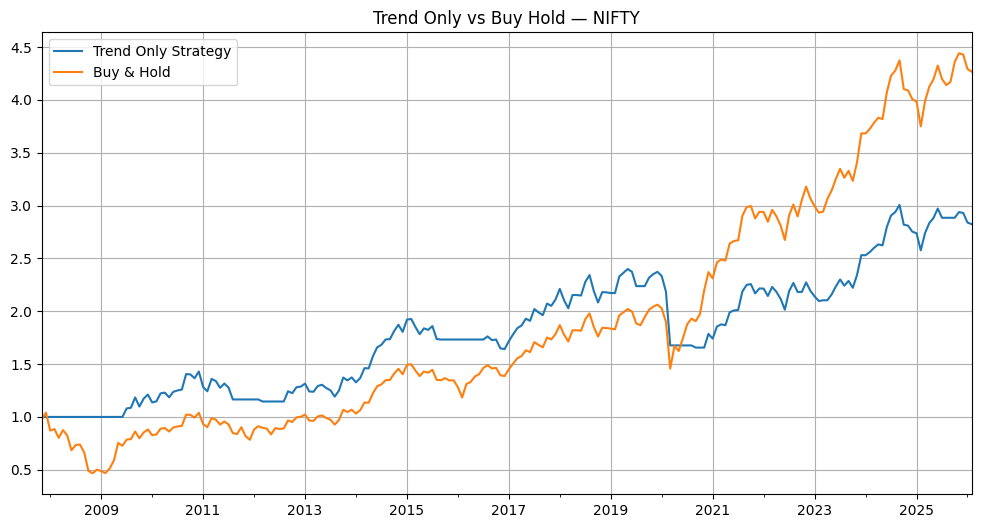


Months Tested: 220
Trend CAGR: 5.82 %
Buy Hold CAGR: 8.24 %


In [ ]:
# ===============================
# TREND ONLY BACKTEST (CORRECTED)
# ===============================

import pandas as pd
import matplotlib.pyplot as plt


# -------------------------------
# 1. Monthly Returns
# -------------------------------
monthly_returns = monthly_nifty_series.pct_change().dropna()


# -------------------------------
# 2. Align Using INDEX INTERSECTION
# -------------------------------
common_index = monthly_returns.index.intersection(
    trend_signal.index
)

trend_returns = monthly_returns.loc[common_index]

trend_exposure = (
    trend_signal.loc[common_index, "trend_signal"]
)


# -------------------------------
# 3. NO LOOKAHEAD
# Apply next month
# -------------------------------
trend_exposure = trend_exposure.shift(1).dropna()

trend_returns = trend_returns.loc[
    trend_exposure.index
]


# -------------------------------
# 4. Strategy Returns
# -------------------------------
strategy_returns = trend_returns * trend_exposure


# -------------------------------
# 5. Equity Curves
# -------------------------------
trend_equity = (1 + strategy_returns).cumprod()

buy_hold_equity = (
    1 + monthly_returns.loc[trend_equity.index]
).cumprod()


# -------------------------------
# 6. Plot
# -------------------------------
plt.figure(figsize=(12,6))

trend_equity.plot(label="Trend Only Strategy")
buy_hold_equity.plot(label="Buy & Hold")

plt.title("Trend Only vs Buy Hold — NIFTY")

plt.legend()
plt.grid(True)

plt.show()


# -------------------------------
# 7. Diagnostics
# -------------------------------
years = len(trend_equity)/12

trend_cagr = trend_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(trend_equity))
print("Trend CAGR:", round(trend_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

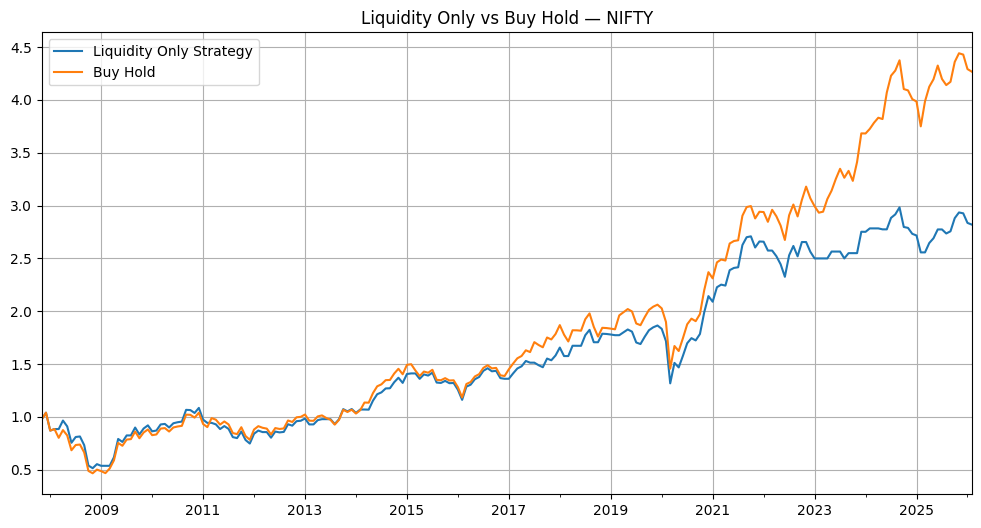


Months Tested: 220
Liquidity CAGR: 5.82 %
Buy Hold CAGR: 8.24 %


In [ ]:
# ===============================
# LIQUIDITY ONLY BACKTEST
# ===============================

import matplotlib.pyplot as plt


# -------------------------------
# 1. Monthly Returns
# -------------------------------
monthly_returns = monthly_nifty_series.pct_change().dropna()


# -------------------------------
# 2. Align Index
# -------------------------------
common_index = monthly_returns.index.intersection(
    regime_signal_monthly.index
)

liq_returns = monthly_returns.loc[common_index]

liq_exposure = regime_signal_monthly.loc[common_index]


# -------------------------------
# 3. NO LOOKAHEAD
# Apply next month
# -------------------------------
liq_exposure = liq_exposure.shift(1).dropna()

liq_returns = liq_returns.loc[liq_exposure.index]


# -------------------------------
# 4. Strategy Returns
# -------------------------------
liq_strategy_returns = liq_returns * liq_exposure


# -------------------------------
# 5. Equity Curves
# -------------------------------
liq_equity = (1 + liq_strategy_returns).cumprod()

buy_hold_equity = (
    1 + monthly_returns.loc[liq_equity.index]
).cumprod()


# -------------------------------
# 6. Plot
# -------------------------------
plt.figure(figsize=(12,6))

liq_equity.plot(label="Liquidity Only Strategy")
buy_hold_equity.plot(label="Buy Hold")

plt.title("Liquidity Only vs Buy Hold — NIFTY")

plt.legend()
plt.grid(True)

plt.show()


# -------------------------------
# 7. Diagnostics
# -------------------------------
years = len(liq_equity)/12

liq_cagr = liq_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(liq_equity))
print("Liquidity CAGR:", round(liq_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

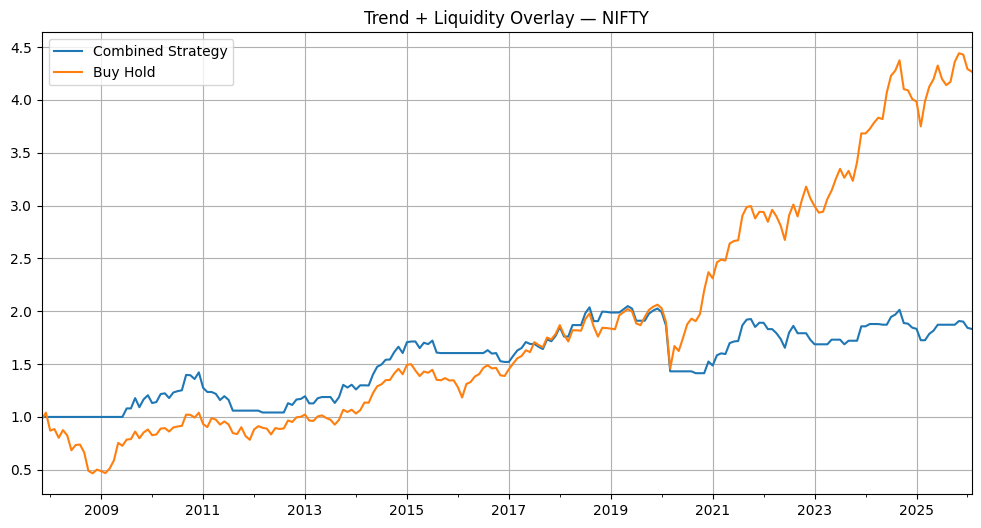


Months Tested: 220
Combined CAGR: 3.36 %
Buy Hold CAGR: 8.24 %


In [ ]:
# ===============================
# COMBINED TREND + LIQUIDITY
# ===============================

import matplotlib.pyplot as plt


# -------------------------------
# 1. Monthly Returns
# -------------------------------
monthly_returns = monthly_nifty_series.pct_change().dropna()


# -------------------------------
# 2. Align All Signals
# -------------------------------
common_index = (
    monthly_returns.index
    .intersection(trend_signal.index)
    .intersection(regime_signal_monthly.index)
)

returns = monthly_returns.loc[common_index]

trend_exp = trend_signal.loc[
    common_index, "trend_signal"
]

liq_exp = regime_signal_monthly.loc[
    common_index
]


# -------------------------------
# 3. Combined Exposure
# -------------------------------
combined_exposure = trend_exp * liq_exp


# -------------------------------
# 4. NO LOOKAHEAD
# -------------------------------
combined_exposure = combined_exposure.shift(1).dropna()

returns = returns.loc[
    combined_exposure.index
]


# -------------------------------
# 5. Strategy Returns
# -------------------------------
combined_returns = returns * combined_exposure


# -------------------------------
# 6. Equity Curves
# -------------------------------
combined_equity = (1 + combined_returns).cumprod()

buy_hold_equity = (
    1 + monthly_returns.loc[combined_equity.index]
).cumprod()


# -------------------------------
# 7. Plot
# -------------------------------
plt.figure(figsize=(12,6))

combined_equity.plot(label="Combined Strategy")
buy_hold_equity.plot(label="Buy Hold")

plt.title("Trend + Liquidity Overlay — NIFTY")

plt.legend()
plt.grid(True)

plt.show()


# -------------------------------
# 8. Diagnostics
# -------------------------------
years = len(combined_equity)/12

combined_cagr = combined_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(combined_equity))
print("Combined CAGR:", round(combined_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

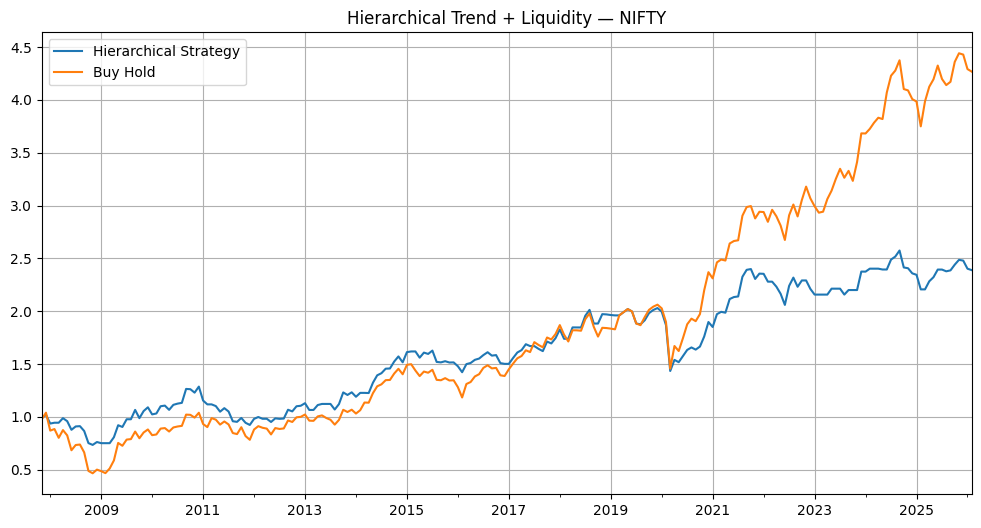


Months Tested: 220
Hierarchical CAGR: 4.86 %
Buy Hold CAGR: 8.24 %


In [ ]:
# ======================================
# HIERARCHICAL TREND + LIQUIDITY STRATEGY
# ======================================

import matplotlib.pyplot as plt
import pandas as pd


# -------------------------------
# 1. Monthly Returns
# -------------------------------
monthly_returns = monthly_nifty_series.pct_change().dropna()


# -------------------------------
# 2. Align Signals + Returns
# -------------------------------
common_index = (
    monthly_returns.index
    .intersection(trend_signal.index)
    .intersection(regime_signal_monthly.index)
)

returns = monthly_returns.loc[common_index]

trend_exp = trend_signal.loc[
    common_index, "trend_signal"
]

liq_exp = regime_signal_monthly.loc[
    common_index
]


# -------------------------------
# 3. Hierarchical Exposure Rule
# -------------------------------
# Liquidity OFF → 0
# Liquidity ON + Trend ON → 1.0
# Liquidity ON + Trend OFF → 0.5

hierarchical_exposure = pd.Series(
    0.0,
    index=common_index
)

hierarchical_exposure[
    (liq_exp == 1) & (trend_exp == 1)
] = 1.0

hierarchical_exposure[
    (liq_exp == 1) & (trend_exp == 0)
] = 0.5


# -------------------------------
# 4. NO LOOKAHEAD
# Apply next month
# -------------------------------
hierarchical_exposure = hierarchical_exposure.shift(1).dropna()

returns = returns.loc[
    hierarchical_exposure.index
]


# -------------------------------
# 5. Strategy Returns
# -------------------------------
strategy_returns = returns * hierarchical_exposure


# -------------------------------
# 6. Equity Curves
# -------------------------------
hier_equity = (1 + strategy_returns).cumprod()

buy_hold_equity = (
    1 + monthly_returns.loc[hier_equity.index]
).cumprod()


# -------------------------------
# 7. Plot
# -------------------------------
plt.figure(figsize=(12,6))

hier_equity.plot(label="Hierarchical Strategy")
buy_hold_equity.plot(label="Buy Hold")

plt.title("Hierarchical Trend + Liquidity — NIFTY")

plt.legend()
plt.grid(True)

plt.show()


# -------------------------------
# 8. Diagnostics
# -------------------------------
years = len(hier_equity)/12

hier_cagr = hier_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(hier_equity))
print("Hierarchical CAGR:", round(hier_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

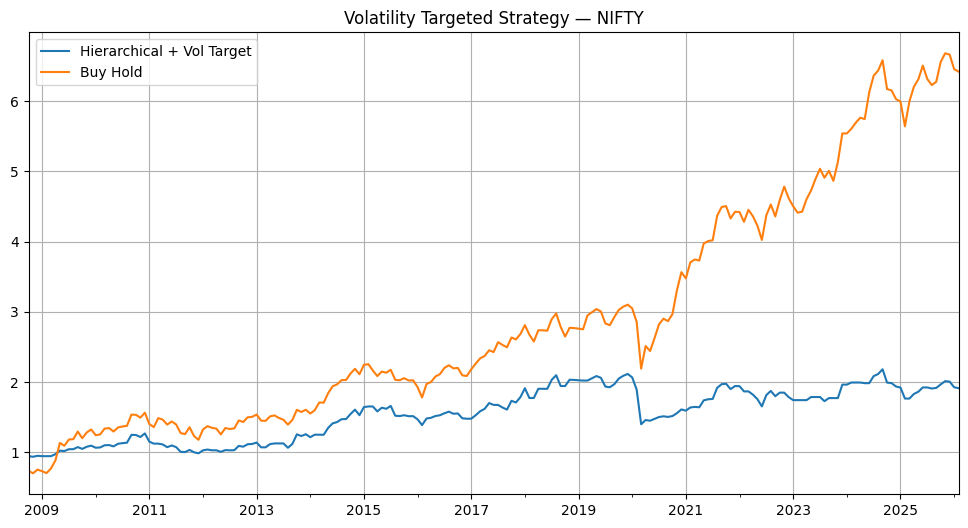


Months Tested: 209
Strategy CAGR: 3.8 %
Buy Hold CAGR: 11.27 %


In [ ]:
# ======================================
# HIERARCHICAL + VOLATILITY TARGETING
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -------------------------------
# 1. Monthly Returns
# -------------------------------
monthly_returns = monthly_nifty_series.pct_change().dropna()


# -------------------------------
# 2. Align Signals + Returns
# -------------------------------
common_index = (
    monthly_returns.index
    .intersection(trend_signal.index)
    .intersection(regime_signal_monthly.index)
)

returns = monthly_returns.loc[common_index]

trend_exp = trend_signal.loc[common_index, "trend_signal"]
liq_exp = regime_signal_monthly.loc[common_index]


# -------------------------------
# 3. Hierarchical Exposure
# -------------------------------
hier_exp = pd.Series(0.0, index=common_index)

hier_exp[(liq_exp == 1) & (trend_exp == 1)] = 1.0
hier_exp[(liq_exp == 1) & (trend_exp == 0)] = 0.5


# -------------------------------
# 4. Realized Volatility (12M Rolling)
# -------------------------------
rolling_vol = (
    returns.rolling(12).std() * np.sqrt(12)
)


# -------------------------------
# 5. Volatility Targeting
# -------------------------------
TARGET_VOL = 0.15
MAX_LEVERAGE = 1.5

vol_scaler = TARGET_VOL / rolling_vol

# Cap leverage
vol_scaler = vol_scaler.clip(upper=MAX_LEVERAGE)

# Replace infinite values (early periods)
vol_scaler = vol_scaler.replace([np.inf, -np.inf], np.nan)


# -------------------------------
# 6. Final Weight
# -------------------------------
final_weight = hier_exp * vol_scaler

# No lookahead
final_weight = final_weight.shift(1)

# Drop NaNs from early rolling window
final_weight = final_weight.dropna()

returns = returns.loc[final_weight.index]


# -------------------------------
# 7. Strategy Returns
# -------------------------------
strategy_returns = returns * final_weight


# -------------------------------
# 8. Equity Curves
# -------------------------------
strategy_equity = (1 + strategy_returns).cumprod()

buy_hold_equity = (
    1 + monthly_returns.loc[strategy_equity.index]
).cumprod()


# -------------------------------
# 9. Plot
# -------------------------------
plt.figure(figsize=(12,6))

strategy_equity.plot(label="Hierarchical + Vol Target")
buy_hold_equity.plot(label="Buy Hold")

plt.title("Volatility Targeted Strategy — NIFTY")

plt.legend()
plt.grid(True)
plt.show()


# -------------------------------
# 10. Diagnostics
# -------------------------------
years = len(strategy_equity) / 12

strategy_cagr = strategy_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(strategy_equity))
print("Strategy CAGR:", round(strategy_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

In [ ]:
# ======================================
# PERFORMANCE METRICS ENGINE (PROTOTYPE)
# ======================================

import numpy as np
import pandas as pd


def performance_metrics(returns, name="Strategy"):
    
    returns = returns.dropna()
    
    # Annualization factor (monthly data)
    ann_factor = 12
    
    # CAGR
    cumulative = (1 + returns).cumprod()
    years = len(returns) / ann_factor
    cagr = cumulative.iloc[-1]**(1/years) - 1
    
    # Volatility
    vol = returns.std() * np.sqrt(ann_factor)
    
    # Sharpe (risk-free assumed 0 for now)
    sharpe = (returns.mean() * ann_factor) / vol
    
    # Sortino
    downside = returns[returns < 0]
    downside_vol = downside.std() * np.sqrt(ann_factor)
    sortino = (returns.mean() * ann_factor) / downside_vol
    
    # Max Drawdown
    rolling_max = cumulative.cummax()
    drawdown = cumulative / rolling_max - 1
    max_dd = drawdown.min()
    
    # Calmar
    calmar = cagr / abs(max_dd)
    
    return {
        "CAGR": round(cagr * 100, 2),
        "Volatility": round(vol * 100, 2),
        "Sharpe": round(sharpe, 2),
        "Sortino": round(sortino, 2),
        "Max Drawdown": round(max_dd * 100, 2),
        "Calmar": round(calmar, 2)
    }


# ======================================
# COLLECT STRATEGIES
# ======================================

results = {}

results["Buy & Hold"] = performance_metrics(
    monthly_returns.loc[strategy_returns.index], 
    "BuyHold"
)

results["Trend Only"] = performance_metrics(
    trend_returns * trend_exposure,
    "Trend"
)

results["Liquidity Only"] = performance_metrics(
    liq_strategy_returns,
    "Liquidity"
)

results["Hierarchical"] = performance_metrics(
    returns * hierarchical_exposure,
    "Hierarchical"
)

results["Vol Targeted"] = performance_metrics(
    strategy_returns,
    "VolTarget"
)

results["CrashGuard"] = performance_metrics(
    cg_returns,
    "CrashGuard"
)
metrics_df = pd.DataFrame(results).T

metrics_df

,CAGR,Volatility,Sharpe,Sortino,Max Drawdown,Calmar
Buy & Hold,11.27,19.16,0.66,0.91,-29.34,0.38
Trend Only,5.82,13.60,0.49,0.58,-30.99,0.19
Liquidity Only,5.82,19.25,0.39,0.47,-50.48,0.12
Hierarchical,4.86,14.56,0.40,0.49,-29.34,0.17
Vol Targeted,3.80,13.73,0.34,0.38,-33.83,0.11
CrashGuard,7.33,19.73,0.46,0.59,-55.12,0.13


In [ ]:
# ======================================
# REGIME QUALITY TEST
# ======================================

regime_monthly = regime_signal_monthly.copy()

# Align with returns
common_index = monthly_returns.index.intersection(regime_monthly.index)

test_returns = monthly_returns.loc[common_index]
test_regime = regime_monthly.loc[common_index]

# Next month application (no leakage)
test_regime = test_regime.shift(1).dropna()
test_returns = test_returns.loc[test_regime.index]

risk_on_returns = test_returns[test_regime == 1]
risk_off_returns = test_returns[test_regime == 0]

print("Avg Monthly Return | Risk ON :", round(risk_on_returns.mean()*100,2), "%")
print("Avg Monthly Return | Risk OFF:", round(risk_off_returns.mean()*100,2), "%")

print("\nNumber of Risk ON months :", len(risk_on_returns))
print("Number of Risk OFF months:", len(risk_off_returns))

Avg Monthly Return | Risk ON : 0.73 %
Avg Monthly Return | Risk OFF: 1.45 %

Number of Risk ON months : 189
Number of Risk OFF months: 31


In [ ]:
# ======================================
# CRASH PROTECTION TEST
# ======================================

# Worst 20% equity months
threshold = test_returns.quantile(0.2)

bad_months = test_returns <= threshold

bad_month_returns = test_returns[bad_months]

bad_regime = test_regime.loc[bad_month_returns.index]

risk_on_bad = bad_month_returns[bad_regime == 1]
risk_off_bad = bad_month_returns[bad_regime == 0]

print("Avg BAD month return | Risk ON :", round(risk_on_bad.mean()*100,2), "%")
print("Avg BAD month return | Risk OFF:", round(risk_off_bad.mean()*100,2), "%")

print("\nCount Risk ON bad months :", len(risk_on_bad))
print("Count Risk OFF bad months:", len(risk_off_bad))

Avg BAD month return | Risk ON : -7.0 %
Avg BAD month return | Risk OFF: -5.16 %

Count Risk ON bad months : 39
Count Risk OFF bad months: 5


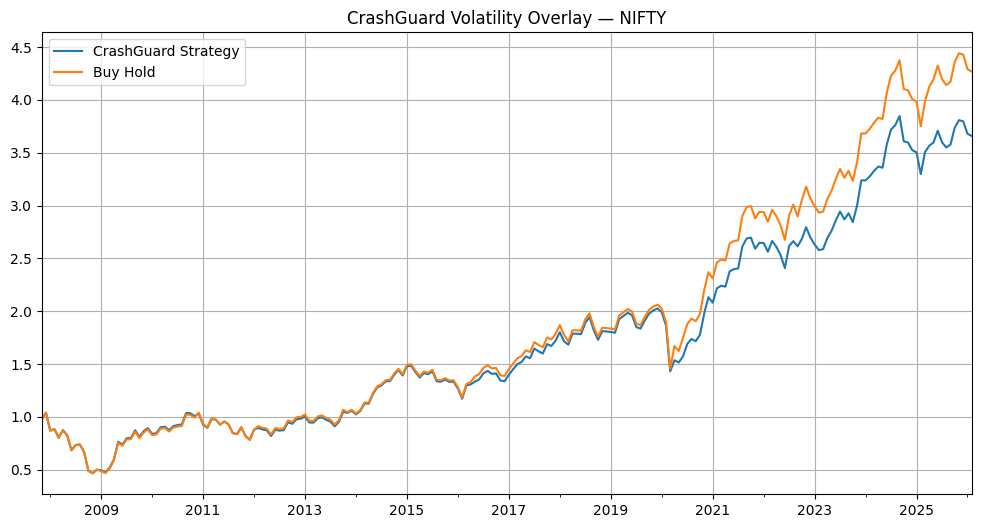


Months Tested: 220
CrashGuard CAGR: 7.33 %
Buy Hold CAGR: 8.24 %


In [ ]:
# ======================================
# CRASHGUARD — VOL SHOCK OVERLAY
# ======================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -------------------------------
# 1. Monthly Returns
# -------------------------------
monthly_returns = monthly_nifty_series.pct_change().dropna()


# -------------------------------
# 2. Volatility Measures
# -------------------------------

short_vol = (
    monthly_returns.rolling(3).std() * np.sqrt(12)
)

long_vol = (
    monthly_returns.rolling(12).std() * np.sqrt(12)
)


# -------------------------------
# 3. Stress Detection
# -------------------------------

VOL_THRESHOLD = 1.5

stress_signal = (short_vol > VOL_THRESHOLD * long_vol).astype(int)

# Stress = 1 means reduce risk


# -------------------------------
# 4. Exposure Rule
# -------------------------------

# normal = 1
# stress = 0.5

crashguard_exposure = pd.Series(
    1.0,
    index=monthly_returns.index
)

crashguard_exposure[stress_signal == 1] = 0.5


# -------------------------------
# 5. NO LOOKAHEAD
# -------------------------------

crashguard_exposure = crashguard_exposure.shift(1).dropna()

returns = monthly_returns.loc[
    crashguard_exposure.index
]


# -------------------------------
# 6. Strategy Returns
# -------------------------------

cg_returns = returns * crashguard_exposure


# -------------------------------
# 7. Equity Curves
# -------------------------------

cg_equity = (1 + cg_returns).cumprod()

buy_hold_equity = (
    1 + monthly_returns.loc[cg_equity.index]
).cumprod()


# -------------------------------
# 8. Plot
# -------------------------------

plt.figure(figsize=(12,6))

cg_equity.plot(label="CrashGuard Strategy")
buy_hold_equity.plot(label="Buy Hold")

plt.title("CrashGuard Volatility Overlay — NIFTY")

plt.legend()
plt.grid(True)

plt.show()


# -------------------------------
# 9. Diagnostics
# -------------------------------

years = len(cg_equity)/12

cg_cagr = cg_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(cg_equity))
print("CrashGuard CAGR:", round(cg_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

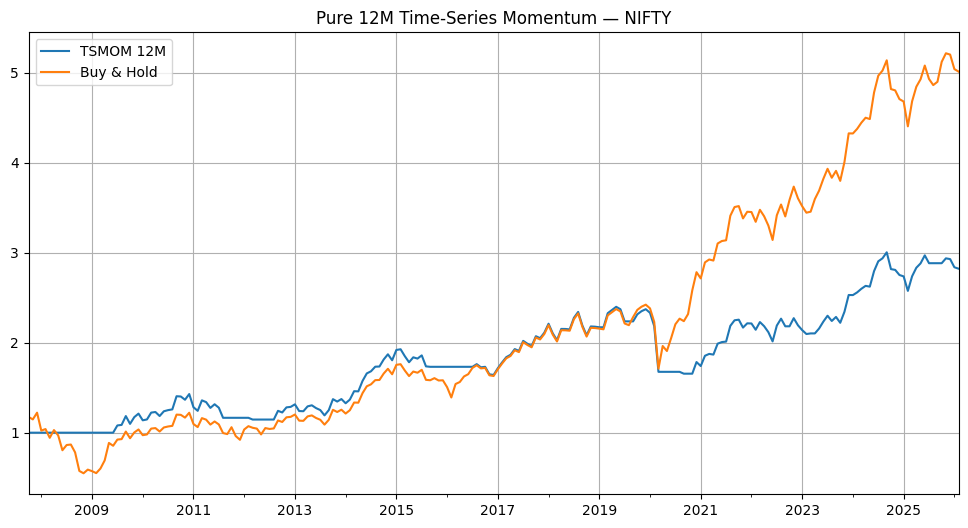


Months Tested: 221
TSMOM CAGR: 5.8 %
Buy Hold CAGR: 9.15 %


In [ ]:
# ======================================
# PURE 12M TIME-SERIES MOMENTUM
# ======================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -------------------------------
# 1. Monthly Returns
# -------------------------------
monthly_returns = monthly_nifty_series.pct_change().dropna()


# -------------------------------
# 2. 12M Momentum Signal
# -------------------------------

lookback = 12

momentum_signal = (
    monthly_nifty_series.pct_change(lookback)
)

# Long if positive trailing 12M return
tsmom_signal = (momentum_signal > 0).astype(int)

# No lookahead
tsmom_signal = tsmom_signal.shift(1)


# -------------------------------
# 3. Align Index
# -------------------------------

common_index = monthly_returns.index.intersection(tsmom_signal.index)

returns = monthly_returns.loc[common_index]
signal = tsmom_signal.loc[common_index]


# -------------------------------
# 4. Strategy Returns
# -------------------------------

tsmom_returns = returns * signal


# -------------------------------
# 5. Equity Curves
# -------------------------------

tsmom_equity = (1 + tsmom_returns).cumprod()
buy_hold_equity = (1 + returns).cumprod()


# -------------------------------
# 6. Plot
# -------------------------------

plt.figure(figsize=(12,6))

tsmom_equity.plot(label="TSMOM 12M")
buy_hold_equity.plot(label="Buy & Hold")

plt.title("Pure 12M Time-Series Momentum — NIFTY")

plt.legend()
plt.grid(True)

plt.show()


# -------------------------------
# 7. Quick Diagnostics
# -------------------------------

years = len(tsmom_equity)/12

tsmom_cagr = tsmom_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(tsmom_equity))
print("TSMOM CAGR:", round(tsmom_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

In [ ]:
df[["NIFTY","GLD"]].tail()

,NIFTY,GLD
2026-02-23,25713.000000,481.279999
2026-02-24,25424.650391,474.609985
2026-02-25,25482.500000,473.420013
2026-02-26,25496.550781,477.480011
2026-02-27,25178.650391,483.750000


In [ ]:
# ======================================
# MONTHLY ALIGNMENT — NIFTY & GLD
# ======================================

# 1️⃣ Extract Daily Prices
daily_prices = df[["NIFTY", "GLD"]].dropna()

# 2️⃣ Convert to Month-End Close
monthly_prices = (
    daily_prices
    .resample("ME")
    .last()
)

# 3️⃣ Monthly Returns
monthly_returns = monthly_prices.pct_change().dropna()

# Quick sanity check
print("Monthly shape:", monthly_returns.shape)
monthly_returns.tail()

Monthly shape: (221, 2)


,NIFTY,GLD
2025-10-31,0.045142,0.035587
2025-11-30,0.018694,0.053678
2025-12-31,-0.002799,0.021734
2026-01-31,-0.030959,0.122732
2026-02-28,-0.005608,0.087201


In [ ]:
# ======================================
# REBUILD LIQUIDITY REGIME SIGNAL
# ======================================

from src.regime_engine import RegimeEngine

# 1️⃣ Fit regime model on full history (for now)
engine = RegimeEngine()
engine.fit(df)

# 2️⃣ Predict daily regime
regime_signal = engine.predict(df)

# 3️⃣ Convert to monthly (month-end)
regime_signal_monthly = (
    regime_signal
    .resample("ME")
    .last()
)

regime_signal_monthly.name = "regime_signal"

regime_signal_monthly.head()

1995-01-31    None
1995-02-28    None
1995-03-31    None
1995-04-30    None
1995-05-31    None
Freq: ME, Name: regime_signal, dtype: object

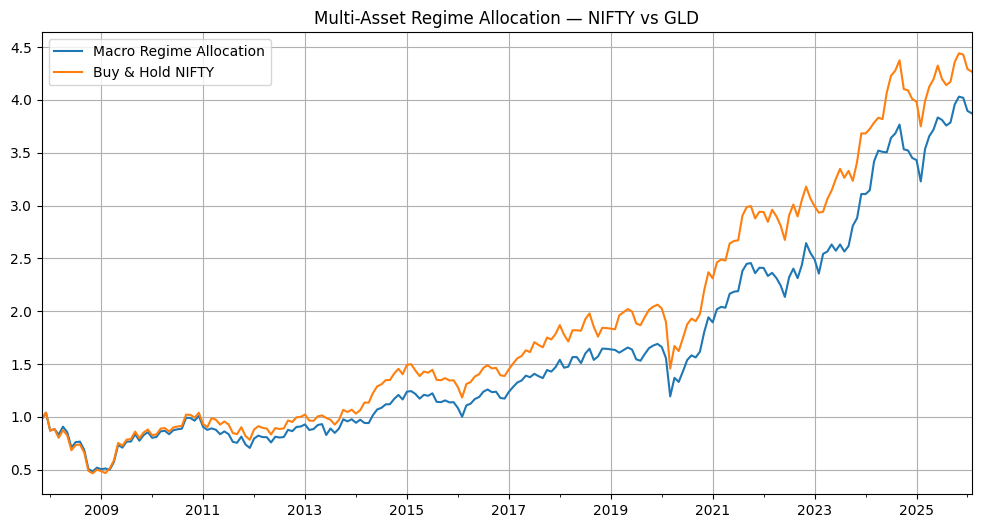


Months Tested: 220
Allocation CAGR: 7.67 %
Buy Hold CAGR: 8.24 %


In [ ]:
# ======================================
# MULTI-ASSET REGIME ALLOCATION
# NIFTY vs GLD (Fixed Version)
# ======================================

# 1️⃣ Convert regime to numeric
regime_numeric = regime_signal_monthly.replace({
    "risk_on": 1,
    "neutral": 1,
    "risk_off": 0
})

# 2️⃣ Align with monthly returns
common_index = monthly_returns.index.intersection(regime_numeric.index)

returns = monthly_returns.loc[common_index]
regime = regime_numeric.loc[common_index]

# No lookahead
regime = regime.shift(1).dropna()
returns = returns.loc[regime.index]

# 3️⃣ Allocation Rule
allocation_returns = (
    regime * returns["NIFTY"] +
    (1 - regime) * returns["GLD"]
)

# 4️⃣ Equity
alloc_equity = (1 + allocation_returns).cumprod()
buy_hold_equity = (1 + returns["NIFTY"]).cumprod()

# 5️⃣ Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
alloc_equity.plot(label="Macro Regime Allocation")
buy_hold_equity.plot(label="Buy & Hold NIFTY")
plt.title("Multi-Asset Regime Allocation — NIFTY vs GLD")
plt.legend()
plt.grid(True)
plt.show()

# 6️⃣ CAGR
years = len(alloc_equity) / 12

alloc_cagr = alloc_equity.iloc[-1]**(1/years) - 1
bh_cagr = buy_hold_equity.iloc[-1]**(1/years) - 1

print("\nMonths Tested:", len(alloc_equity))
print("Allocation CAGR:", round(alloc_cagr*100,2), "%")
print("Buy Hold CAGR:", round(bh_cagr*100,2), "%")

In [38]:
df[["NIFTY", "GLD", "SPY"]].tail()

,NIFTY,GLD,SPY
2026-02-23,25713.000000,481.279999,682.390015
2026-02-24,25424.650391,474.609985,687.349976
2026-02-25,25482.500000,473.420013,693.150024
2026-02-26,25496.550781,477.480011,689.299988
2026-02-27,25178.650391,483.750000,685.989990


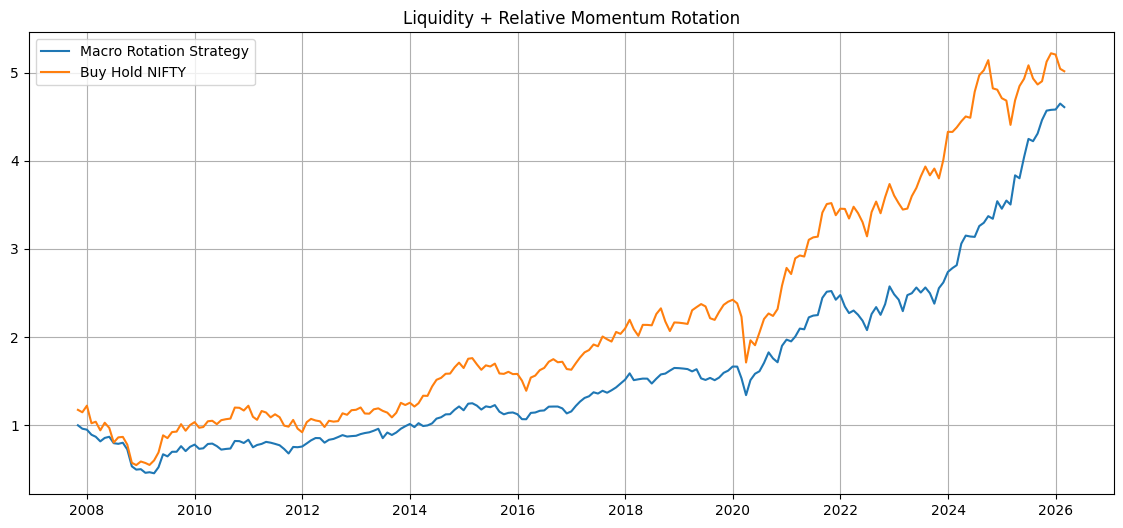


Months Tested: 221
Allocation CAGR: 8.65 %
Buy Hold CAGR: 9.15 %


In [40]:
# ============================================================
# MULTI ASSET MACRO ROTATION
# Liquidity Regime + Relative Momentum
# NIFTY vs SPY vs GLD
# ============================================================

from src.regime_engine import RegimeEngine
import matplotlib.pyplot as plt
import pandas as pd


# ============================================================
# 1️⃣ BUILD REGIME SIGNAL (DAILY → MONTHLY)
# ============================================================

engine = RegimeEngine()

engine.fit(df)

daily_regime = engine.predict(df)

regime_binary = daily_regime.replace({
    "risk_on":1,
    "neutral":1,
    "risk_off":0
})

regime_signal_monthly = (
    regime_binary
    .resample("ME")
    .last()
)

regime_signal_monthly.name = "regime"



# ============================================================
# 2️⃣ MONTHLY PRICES + RETURNS
# ============================================================

monthly_prices = (
    df[["NIFTY","SPY","GLD"]]
    .dropna()
    .resample("ME")
    .last()
)

monthly_returns = monthly_prices.pct_change().dropna()



# ============================================================
# 3️⃣ 12M MOMENTUM (NO LOOKAHEAD)
# ============================================================

momentum_12m = monthly_prices.pct_change(12)



# ============================================================
# 4️⃣ ALIGN EVERYTHING
# ============================================================

common_index = (
    monthly_returns.index
    .intersection(momentum_12m.index)
    .intersection(regime_signal_monthly.index)
)

returns = monthly_returns.loc[common_index]

momentum = momentum_12m.loc[common_index]

regime = regime_signal_monthly.loc[common_index]



# ============================================================
# 5️⃣ BUILD ALLOCATION
# ============================================================

weights = pd.DataFrame(
    0,
    index=returns.index,
    columns=returns.columns
)


for date in returns.index:

    # Risk ON → strongest equity
    if regime.loc[date] == 1:

        if momentum.loc[date,"NIFTY"] > momentum.loc[date,"SPY"]:
            weights.loc[date,"NIFTY"] = 1
        else:
            weights.loc[date,"SPY"] = 1

    # Risk OFF → Gold
    else:
        weights.loc[date,"GLD"] = 1



# ============================================================
# 6️⃣ APPLY NEXT MONTH (NO LOOKAHEAD)
# ============================================================

shifted_weights = weights.shift(1)



# ============================================================
# 7️⃣ PORTFOLIO RETURNS
# ============================================================

portfolio_returns = (
    shifted_weights * returns
).sum(axis=1)



# ============================================================
# 8️⃣ EQUITY CURVES
# ============================================================

alloc_equity = (1 + portfolio_returns).cumprod()

bh_equity = (
    1 + returns["NIFTY"]
).cumprod()



# ============================================================
# 9️⃣ PLOT
# ============================================================

plt.figure(figsize=(14,6))

plt.plot(
    alloc_equity,
    label="Macro Rotation Strategy"
)

plt.plot(
    bh_equity,
    label="Buy Hold NIFTY"
)

plt.title("Liquidity + Relative Momentum Rotation")

plt.legend()

plt.grid(True)

plt.show()



# ============================================================
# 🔟 CAGR
# ============================================================

years = len(alloc_equity)/12

alloc_cagr = alloc_equity.iloc[-1]**(1/years)-1

bh_cagr = bh_equity.iloc[-1]**(1/years)-1


print("\nMonths Tested:",len(alloc_equity))

print("Allocation CAGR:",round(alloc_cagr*100,2),"%")

print("Buy Hold CAGR:",round(bh_cagr*100,2),"%")